In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#downloading the dataset with 1024 of gaussian noise
url = "https://drive.google.com/u/0/uc?id=19QawTR73YtVd2-qnFbWFb0s5HFDhnsgx&export=download"
output = "data_gaussian_1024.zip"
gdown.download(url, output)
!unzip data_gaussian_1024.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=19QawTR73YtVd2-qnFbWFb0s5HFDhnsgx&export=download
From (redirected): https://drive.google.com/uc?id=19QawTR73YtVd2-qnFbWFb0s5HFDhnsgx&export=download&confirm=t&uuid=9e8be69f-cd09-4395-8f0d-0b0301d94b23
To: /content/data_gaussian_1024.zip
100%|██████████| 95.5M/95.5M [00:03<00:00, 28.0MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_gaussian_1024/jammed_channel/images/2_104.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_105.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_106.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_107.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_108.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_109.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_110.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_111.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_112.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_113.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_114.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_115.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_116.png  
  inflating: data_gaussian_1024/jammed_channel/images/2_117.png  
  inflating: data_gaussian

In [5]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("data_gaussian_1024")):
  print(folder)
  for im in tqdm(os.listdir("data_gaussian_1024/"+folder+"/images/")):
      if folder == "clean":
          clean.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_clean.append(0)
      elif folder == "clean_validation":
          val.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_val.append(0)
      elif folder== "jammed_channel":
          anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_anomalies.append(1)
      else:
        test.append(cv.cvtColor(cv.resize(cv.imread("data_gaussian_1024/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
        labels_test.append(mapping[int(im[0])])
  ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

clean_validation



 25%|██▌       | 1/4 [00:05<00:16,  5.38s/it]

jammed_channel



 50%|█████     | 2/4 [00:12<00:12,  6.11s/it]

test



 75%|███████▌  | 3/4 [00:23<00:08,  8.60s/it]

clean



100%|██████████| 4/4 [00:47<00:00, 11.99s/it]


In [6]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [7]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



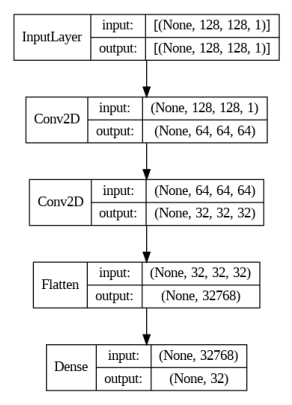

Summary of the decoder:



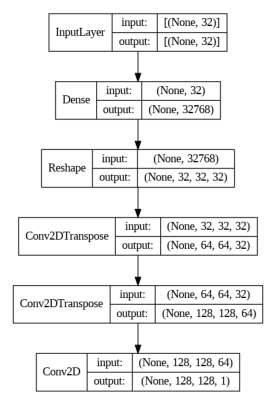

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [9]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 20s 49ms/step - loss: 0.0204 - val_loss: 0.0152
Epoch 2/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0147 - val_loss: 0.0151
Epoch 3/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 4/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 5/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0145 - val_loss: 0.0149
Epoch 6/20
125/125 [==============================] - 6s 49ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 7/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 8/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 9/20
125/125 [==============================] - 6s 46ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0109 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

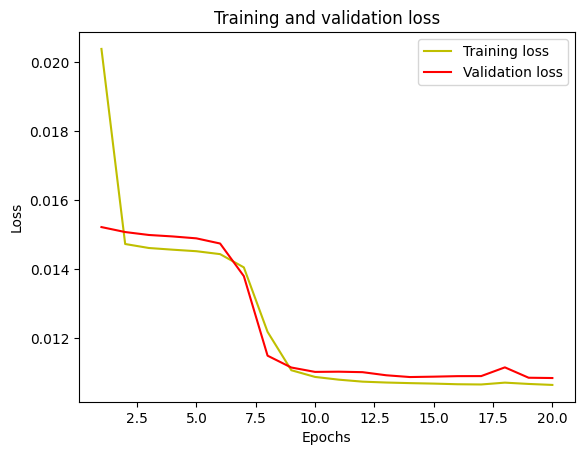

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 21ms/step


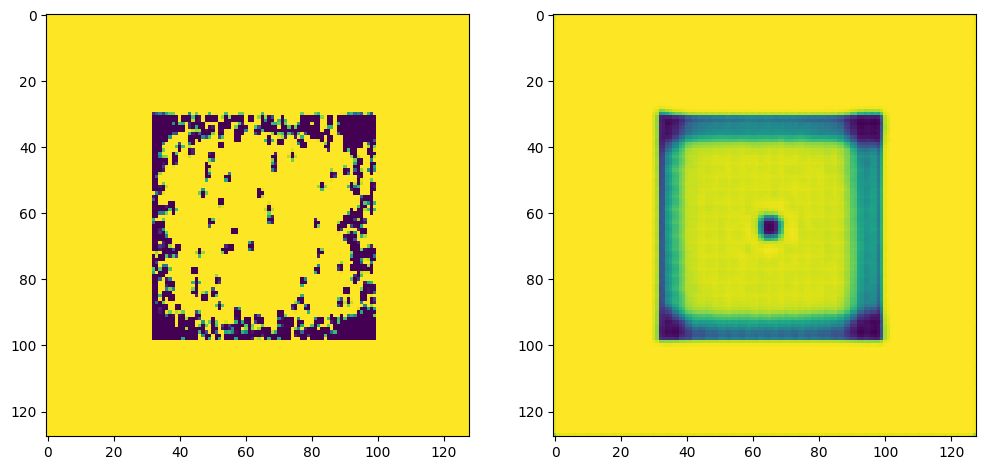

In [12]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [13]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 43ms/step - loss: 0.0528
Validation error 0.010850545018911362
Anomaly error 0.052830614149570465
The reconstruction error of the jammed channel is  4.86893645042643  more than the clean channel


In [14]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [15]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 180ms/step - loss: 0.0049


  0%|          | 1/600 [00:00<02:19,  4.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0170


  0%|          | 3/600 [00:00<01:09,  8.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0167


  1%|          | 4/600 [00:00<01:56,  5.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


  1%|          | 6/600 [00:00<01:20,  7.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0174


  1%|▏         | 8/600 [00:01<01:08,  8.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


  2%|▏         | 10/600 [00:01<01:00,  9.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


  2%|▏         | 12/600 [00:01<00:55, 10.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0172


  2%|▏         | 14/600 [00:01<00:52, 11.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0152


  3%|▎         | 16/600 [00:01<00:52, 11.05it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0050


  3%|▎         | 18/600 [00:01<00:49, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


  3%|▎         | 20/600 [00:02<00:48, 11.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


  4%|▎         | 22/600 [00:02<00:48, 11.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0048


  4%|▍         | 24/600 [00:02<00:48, 11.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0133


  4%|▍         | 26/600 [00:02<00:47, 11.97it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


  5%|▍         | 28/600 [00:02<00:47, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


  5%|▌         | 30/600 [00:02<00:47, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0177


  5%|▌         | 32/600 [00:03<00:47, 11.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


  6%|▌         | 34/600 [00:03<00:46, 12.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0159


  6%|▌         | 36/600 [00:03<00:46, 12.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0149


  6%|▋         | 38/600 [00:03<00:47, 11.71it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


  7%|▋         | 40/600 [00:03<00:48, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0174


  7%|▋         | 42/600 [00:03<00:47, 11.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


  7%|▋         | 44/600 [00:04<00:46, 12.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


  8%|▊         | 46/600 [00:04<00:46, 12.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


  8%|▊         | 48/600 [00:04<00:45, 12.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


  8%|▊         | 50/600 [00:04<00:44, 12.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


  9%|▊         | 52/600 [00:04<00:44, 12.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0132


  9%|▉         | 54/600 [00:04<00:45, 12.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0158


  9%|▉         | 56/600 [00:05<00:44, 12.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0137


 10%|▉         | 58/600 [00:05<00:44, 12.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 10%|█         | 60/600 [00:05<00:43, 12.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 10%|█         | 62/600 [00:05<00:44, 12.13it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 11%|█         | 64/600 [00:05<00:45, 11.74it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0171


 11%|█         | 66/600 [00:05<00:49, 10.72it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0136


 11%|█▏        | 68/600 [00:06<00:52, 10.13it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0172


 12%|█▏        | 70/600 [00:06<00:54,  9.67it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0042


 12%|█▏        | 71/600 [00:06<00:55,  9.47it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 12%|█▏        | 72/600 [00:06<00:56,  9.28it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0042


 12%|█▏        | 73/600 [00:06<00:58,  9.06it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 12%|█▏        | 74/600 [00:06<00:57,  9.22it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0148


 13%|█▎        | 76/600 [00:07<00:55,  9.46it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0186


 13%|█▎        | 77/600 [00:07<00:55,  9.50it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0177


 13%|█▎        | 78/600 [00:07<00:54,  9.60it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 13%|█▎        | 80/600 [00:07<00:52,  9.93it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0152


 14%|█▎        | 82/600 [00:07<00:50, 10.23it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0174


 14%|█▍        | 84/600 [00:07<00:50, 10.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0162


 14%|█▍        | 86/600 [00:07<00:49, 10.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0188


 15%|█▍        | 88/600 [00:08<00:49, 10.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 15%|█▌        | 90/600 [00:08<00:46, 10.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0042


 15%|█▌        | 92/600 [00:08<00:43, 11.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0163


 16%|█▌        | 94/600 [00:08<00:41, 12.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0150


 16%|█▌        | 96/600 [00:08<00:40, 12.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 16%|█▋        | 98/600 [00:08<00:42, 11.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 17%|█▋        | 100/600 [00:09<00:41, 12.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0169


 17%|█▋        | 102/600 [00:09<00:42, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 17%|█▋        | 104/600 [00:09<00:42, 11.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 18%|█▊        | 106/600 [00:09<00:42, 11.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0047


 18%|█▊        | 108/600 [00:09<00:41, 11.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0049


 18%|█▊        | 110/600 [00:10<00:42, 11.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0169


 19%|█▊        | 112/600 [00:10<00:41, 11.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0172


 19%|█▉        | 114/600 [00:10<00:40, 11.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 19%|█▉        | 116/600 [00:10<00:39, 12.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 20%|█▉        | 118/600 [00:10<00:40, 11.91it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0152


 20%|██        | 120/600 [00:10<00:39, 12.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0048


 20%|██        | 122/600 [00:10<00:39, 12.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0176


 21%|██        | 124/600 [00:11<00:39, 12.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 21%|██        | 126/600 [00:11<00:39, 11.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0168


 21%|██▏       | 128/600 [00:11<00:39, 12.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 22%|██▏       | 130/600 [00:11<00:38, 12.09it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 22%|██▏       | 132/600 [00:11<00:38, 12.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0174


 22%|██▏       | 134/600 [00:11<00:39, 11.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0168


 23%|██▎       | 136/600 [00:12<00:38, 12.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 23%|██▎       | 138/600 [00:12<00:37, 12.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0047


 23%|██▎       | 140/600 [00:12<00:37, 12.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 24%|██▎       | 142/600 [00:12<00:37, 12.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0048


 24%|██▍       | 144/600 [00:12<00:37, 12.08it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0168


 24%|██▍       | 146/600 [00:12<00:37, 11.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0140


 25%|██▍       | 148/600 [00:13<00:37, 12.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0190


 25%|██▌       | 150/600 [00:13<00:37, 11.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0153


 25%|██▌       | 152/600 [00:13<00:36, 12.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 26%|██▌       | 154/600 [00:13<00:36, 12.28it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0161


 26%|██▌       | 156/600 [00:13<00:36, 12.21it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0167


 26%|██▋       | 158/600 [00:13<00:37, 11.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0167


 27%|██▋       | 160/600 [00:14<00:36, 11.99it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0173


 27%|██▋       | 162/600 [00:14<00:36, 11.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0161


 27%|██▋       | 164/600 [00:14<00:36, 12.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0154


 28%|██▊       | 166/600 [00:14<00:36, 11.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0172


 28%|██▊       | 168/600 [00:14<00:35, 12.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0042


 28%|██▊       | 170/600 [00:14<00:36, 11.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 29%|██▊       | 172/600 [00:15<00:36, 11.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 29%|██▉       | 174/600 [00:15<00:35, 11.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 29%|██▉       | 176/600 [00:15<00:35, 11.86it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 30%|██▉       | 178/600 [00:15<00:35, 11.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0148


 30%|███       | 180/600 [00:15<00:35, 11.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0170


 30%|███       | 182/600 [00:15<00:35, 11.73it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0174


 31%|███       | 184/600 [00:16<00:35, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 31%|███       | 186/600 [00:16<00:34, 11.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0170


 31%|███▏      | 188/600 [00:16<00:33, 12.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 32%|███▏      | 190/600 [00:16<00:35, 11.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0139


 32%|███▏      | 192/600 [00:16<00:34, 11.75it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0172


 32%|███▏      | 194/600 [00:17<00:34, 11.89it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 33%|███▎      | 196/600 [00:17<00:34, 11.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 33%|███▎      | 198/600 [00:17<00:34, 11.82it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 33%|███▎      | 200/600 [00:17<00:33, 11.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0172


 34%|███▎      | 202/600 [00:17<00:32, 12.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0134


 34%|███▍      | 204/600 [00:17<00:32, 12.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 34%|███▍      | 206/600 [00:18<00:32, 12.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0192


 35%|███▍      | 208/600 [00:18<00:32, 12.21it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0048


 35%|███▌      | 210/600 [00:18<00:36, 10.59it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0168


 35%|███▌      | 212/600 [00:18<00:38,  9.98it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0182


 36%|███▌      | 214/600 [00:18<00:41,  9.30it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0042


 36%|███▌      | 215/600 [00:18<00:41,  9.25it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0162


 36%|███▌      | 216/600 [00:19<00:43,  8.87it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 36%|███▌      | 217/600 [00:19<00:43,  8.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0149


 36%|███▋      | 219/600 [00:19<00:41,  9.23it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0182


 37%|███▋      | 220/600 [00:19<00:40,  9.28it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0043


 37%|███▋      | 221/600 [00:19<00:42,  8.97it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0048


 37%|███▋      | 222/600 [00:19<00:45,  8.33it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0174


 37%|███▋      | 223/600 [00:19<00:45,  8.33it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0175


 37%|███▋      | 224/600 [00:20<00:44,  8.37it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0042


 38%|███▊      | 225/600 [00:20<00:45,  8.16it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0042


 38%|███▊      | 226/600 [00:20<00:45,  8.19it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0176


 38%|███▊      | 227/600 [00:20<00:45,  8.11it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0180


 38%|███▊      | 228/600 [00:20<00:45,  8.25it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0169


 38%|███▊      | 229/600 [00:20<00:45,  8.12it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0173


 38%|███▊      | 230/600 [00:20<00:44,  8.25it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0042


 38%|███▊      | 231/600 [00:20<00:45,  8.04it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0042


 39%|███▊      | 232/600 [00:21<00:46,  7.86it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0128


 39%|███▉      | 233/600 [00:21<00:45,  8.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0047


 39%|███▉      | 235/600 [00:21<00:38,  9.51it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 40%|███▉      | 237/600 [00:21<00:35, 10.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0161


 40%|███▉      | 239/600 [00:21<00:33, 10.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 40%|████      | 241/600 [00:21<00:33, 10.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 40%|████      | 243/600 [00:22<00:31, 11.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0166


 41%|████      | 245/600 [00:22<00:31, 11.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 41%|████      | 247/600 [00:22<00:30, 11.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 42%|████▏     | 249/600 [00:22<00:30, 11.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 42%|████▏     | 251/600 [00:22<00:30, 11.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 42%|████▏     | 253/600 [00:22<00:29, 11.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0150


 42%|████▎     | 255/600 [00:23<00:30, 11.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 43%|████▎     | 257/600 [00:23<00:29, 11.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 43%|████▎     | 259/600 [00:23<00:29, 11.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 44%|████▎     | 261/600 [00:23<00:29, 11.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 44%|████▍     | 263/600 [00:23<00:29, 11.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0134


 44%|████▍     | 265/600 [00:23<00:28, 11.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 44%|████▍     | 267/600 [00:24<00:28, 11.85it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0165


 45%|████▍     | 269/600 [00:24<00:28, 11.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 45%|████▌     | 271/600 [00:24<00:29, 11.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 46%|████▌     | 273/600 [00:24<00:28, 11.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 46%|████▌     | 275/600 [00:24<00:28, 11.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 46%|████▌     | 277/600 [00:24<00:27, 11.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 46%|████▋     | 279/600 [00:25<00:27, 11.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 47%|████▋     | 281/600 [00:25<00:26, 11.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 47%|████▋     | 283/600 [00:25<00:26, 12.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0166


 48%|████▊     | 285/600 [00:25<00:26, 11.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0138


 48%|████▊     | 287/600 [00:25<00:26, 11.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 48%|████▊     | 289/600 [00:25<00:26, 11.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 48%|████▊     | 291/600 [00:26<00:26, 11.86it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0163


 49%|████▉     | 293/600 [00:26<00:25, 11.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 49%|████▉     | 295/600 [00:26<00:25, 11.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0163


 50%|████▉     | 297/600 [00:26<00:25, 11.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 50%|████▉     | 299/600 [00:26<00:25, 11.71it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0049


 50%|█████     | 301/600 [00:26<00:25, 11.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 50%|█████     | 303/600 [00:27<00:25, 11.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0153


 51%|█████     | 305/600 [00:27<00:25, 11.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 51%|█████     | 307/600 [00:27<00:25, 11.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 52%|█████▏    | 309/600 [00:27<00:24, 11.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 52%|█████▏    | 311/600 [00:27<00:23, 12.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0147


 52%|█████▏    | 313/600 [00:28<00:24, 11.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0042


 52%|█████▎    | 315/600 [00:28<00:24, 11.75it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0154


 53%|█████▎    | 317/600 [00:28<00:23, 11.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 53%|█████▎    | 319/600 [00:28<00:24, 11.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 54%|█████▎    | 321/600 [00:28<00:24, 11.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0050


 54%|█████▍    | 323/600 [00:28<00:23, 11.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 54%|█████▍    | 325/600 [00:29<00:23, 11.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 55%|█████▍    | 327/600 [00:29<00:22, 11.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 55%|█████▍    | 329/600 [00:29<00:22, 11.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0394


 55%|█████▌    | 331/600 [00:29<00:22, 11.78it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0171


 56%|█████▌    | 333/600 [00:29<00:22, 11.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 56%|█████▌    | 335/600 [00:29<00:22, 11.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 56%|█████▌    | 337/600 [00:30<00:22, 11.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 56%|█████▋    | 339/600 [00:30<00:22, 11.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0134


 57%|█████▋    | 341/600 [00:30<00:21, 11.82it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 57%|█████▋    | 343/600 [00:30<00:21, 11.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 57%|█████▊    | 345/600 [00:30<00:21, 11.88it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0042


 58%|█████▊    | 347/600 [00:30<00:21, 11.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0423


 58%|█████▊    | 349/600 [00:31<00:20, 12.06it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0047


 58%|█████▊    | 351/600 [00:31<00:21, 11.78it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0162


 59%|█████▉    | 353/600 [00:31<00:25,  9.87it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 59%|█████▉    | 355/600 [00:31<00:26,  9.31it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 59%|█████▉    | 356/600 [00:31<00:27,  8.93it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0171


 60%|█████▉    | 357/600 [00:32<00:28,  8.65it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0185


 60%|█████▉    | 358/600 [00:32<00:27,  8.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 60%|█████▉    | 359/600 [00:32<00:27,  8.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 60%|██████    | 360/600 [00:32<00:27,  8.84it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0177


 60%|██████    | 361/600 [00:32<00:28,  8.38it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0160


 60%|██████    | 362/600 [00:32<00:29,  8.17it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0051


 60%|██████    | 363/600 [00:32<00:28,  8.27it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0042


 61%|██████    | 364/600 [00:32<00:28,  8.40it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0185


 61%|██████    | 365/600 [00:32<00:27,  8.63it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0186


 61%|██████    | 366/600 [00:33<00:27,  8.65it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0174


 61%|██████    | 367/600 [00:33<00:27,  8.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 61%|██████▏   | 368/600 [00:33<00:26,  8.82it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0042


 62%|██████▏   | 369/600 [00:33<00:26,  8.75it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0153


 62%|██████▏   | 370/600 [00:33<00:27,  8.32it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0173


 62%|██████▏   | 371/600 [00:33<00:29,  7.88it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0165


 62%|██████▏   | 372/600 [00:33<00:28,  7.89it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 62%|██████▏   | 373/600 [00:33<00:28,  7.97it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0049


 62%|██████▏   | 374/600 [00:34<00:28,  7.95it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0042


 62%|██████▎   | 375/600 [00:34<00:27,  8.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 63%|██████▎   | 377/600 [00:34<00:23,  9.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 63%|██████▎   | 379/600 [00:34<00:21, 10.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0160


 64%|██████▎   | 381/600 [00:34<00:20, 10.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 64%|██████▍   | 383/600 [00:34<00:19, 11.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 64%|██████▍   | 385/600 [00:35<00:19, 11.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0042


 64%|██████▍   | 387/600 [00:35<00:19, 11.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 65%|██████▍   | 389/600 [00:35<00:18, 11.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0048


 65%|██████▌   | 391/600 [00:35<00:18, 11.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 66%|██████▌   | 393/600 [00:35<00:17, 11.56it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0166


 66%|██████▌   | 395/600 [00:35<00:18, 11.25it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0042


 66%|██████▌   | 397/600 [00:36<00:18, 11.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0047


 66%|██████▋   | 399/600 [00:36<00:17, 11.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 67%|██████▋   | 401/600 [00:36<00:17, 11.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0047


 67%|██████▋   | 403/600 [00:36<00:17, 11.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0172


 68%|██████▊   | 405/600 [00:36<00:16, 11.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0150


 68%|██████▊   | 407/600 [00:36<00:16, 11.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0174


 68%|██████▊   | 409/600 [00:37<00:16, 11.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 68%|██████▊   | 411/600 [00:37<00:16, 11.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 69%|██████▉   | 413/600 [00:37<00:16, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0048


 69%|██████▉   | 415/600 [00:37<00:15, 11.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0168


 70%|██████▉   | 417/600 [00:37<00:15, 11.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0051


 70%|██████▉   | 419/600 [00:38<00:15, 11.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 70%|███████   | 421/600 [00:38<00:15, 11.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0049


 70%|███████   | 423/600 [00:38<00:15, 11.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0050


 71%|███████   | 425/600 [00:38<00:15, 11.57it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 71%|███████   | 427/600 [00:38<00:15, 11.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 72%|███████▏  | 429/600 [00:38<00:14, 11.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 72%|███████▏  | 431/600 [00:39<00:14, 11.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0153


 72%|███████▏  | 433/600 [00:39<00:14, 11.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0171


 72%|███████▎  | 435/600 [00:39<00:14, 11.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 73%|███████▎  | 437/600 [00:39<00:13, 11.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0143


 73%|███████▎  | 439/600 [00:39<00:13, 11.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0164


 74%|███████▎  | 441/600 [00:39<00:13, 11.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0171


 74%|███████▍  | 443/600 [00:40<00:13, 11.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0158


 74%|███████▍  | 445/600 [00:40<00:13, 11.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0048


 74%|███████▍  | 447/600 [00:40<00:13, 11.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0149


 75%|███████▍  | 449/600 [00:40<00:12, 11.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0048


 75%|███████▌  | 451/600 [00:40<00:13, 11.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 76%|███████▌  | 453/600 [00:40<00:12, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 76%|███████▌  | 455/600 [00:41<00:12, 11.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0176


 76%|███████▌  | 457/600 [00:41<00:12, 11.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 76%|███████▋  | 459/600 [00:41<00:12, 11.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0154


 77%|███████▋  | 461/600 [00:41<00:11, 11.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0161


 77%|███████▋  | 463/600 [00:41<00:11, 11.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0162


 78%|███████▊  | 465/600 [00:41<00:11, 11.85it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0177


 78%|███████▊  | 467/600 [00:42<00:11, 11.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0169


 78%|███████▊  | 469/600 [00:42<00:12, 10.76it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 78%|███████▊  | 471/600 [00:42<00:11, 10.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0160


 79%|███████▉  | 473/600 [00:42<00:11, 11.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0175


 79%|███████▉  | 475/600 [00:42<00:11, 10.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0165


 80%|███████▉  | 477/600 [00:43<00:11, 11.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0157


 80%|███████▉  | 479/600 [00:43<00:10, 11.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0162


 80%|████████  | 481/600 [00:43<00:10, 11.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0048


 80%|████████  | 483/600 [00:43<00:10, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0049


 81%|████████  | 485/600 [00:43<00:09, 11.77it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 81%|████████  | 487/600 [00:43<00:09, 11.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0175


 82%|████████▏ | 489/600 [00:44<00:09, 11.62it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0042


 82%|████████▏ | 491/600 [00:44<00:09, 10.94it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0180


 82%|████████▏ | 493/600 [00:44<00:10, 10.39it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0048


 82%|████████▎ | 495/600 [00:44<00:10,  9.76it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0170


 83%|████████▎ | 496/600 [00:44<00:10,  9.48it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0172


 83%|████████▎ | 497/600 [00:44<00:11,  9.34it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0175


 83%|████████▎ | 498/600 [00:45<00:10,  9.32it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0146


 83%|████████▎ | 499/600 [00:45<00:10,  9.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0042


 84%|████████▎ | 501/600 [00:45<00:10,  9.54it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0042


 84%|████████▎ | 502/600 [00:45<00:10,  9.34it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0165


 84%|████████▍ | 503/600 [00:45<00:10,  9.03it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0153


 84%|████████▍ | 504/600 [00:45<00:10,  9.07it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0049


 84%|████████▍ | 505/600 [00:45<00:10,  8.73it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0048


 84%|████████▍ | 506/600 [00:45<00:11,  8.31it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0042


 84%|████████▍ | 507/600 [00:46<00:11,  8.11it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0163


 85%|████████▍ | 508/600 [00:46<00:10,  8.39it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 85%|████████▍ | 509/600 [00:46<00:10,  8.75it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0049


 85%|████████▌ | 511/600 [00:46<00:09,  9.15it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0042


 85%|████████▌ | 512/600 [00:46<00:09,  9.19it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 86%|████████▌ | 513/600 [00:46<00:09,  9.34it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0166


 86%|████████▌ | 514/600 [00:46<00:09,  9.07it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0165


 86%|████████▌ | 515/600 [00:47<00:10,  8.31it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0042


 86%|████████▌ | 516/600 [00:47<00:09,  8.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0178


 86%|████████▌ | 517/600 [00:47<00:09,  8.79it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0042


 86%|████████▋ | 518/600 [00:47<00:09,  8.53it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0050


 86%|████████▋ | 519/600 [00:47<00:09,  8.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0047


 87%|████████▋ | 520/600 [00:47<00:09,  8.50it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0173


 87%|████████▋ | 522/600 [00:47<00:08,  9.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0172


 87%|████████▋ | 524/600 [00:47<00:07, 10.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 88%|████████▊ | 526/600 [00:48<00:07, 10.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0174


 88%|████████▊ | 528/600 [00:48<00:06, 10.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0171


 88%|████████▊ | 530/600 [00:48<00:06, 11.20it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0162


 89%|████████▊ | 532/600 [00:48<00:06, 11.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 89%|████████▉ | 534/600 [00:48<00:05, 11.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0173


 89%|████████▉ | 536/600 [00:48<00:05, 11.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0167


 90%|████████▉ | 538/600 [00:49<00:05, 11.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0176


 90%|█████████ | 540/600 [00:49<00:05, 11.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


 90%|█████████ | 542/600 [00:49<00:05, 11.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 91%|█████████ | 544/600 [00:49<00:04, 11.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0162


 91%|█████████ | 546/600 [00:49<00:04, 11.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0157


 91%|█████████▏| 548/600 [00:50<00:04, 11.33it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


 92%|█████████▏| 550/600 [00:50<00:04, 11.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 92%|█████████▏| 552/600 [00:50<00:04, 11.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0170


 92%|█████████▏| 554/600 [00:50<00:04, 10.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0165


 93%|█████████▎| 556/600 [00:50<00:04, 10.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0176


 93%|█████████▎| 558/600 [00:50<00:03, 10.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 93%|█████████▎| 560/600 [00:51<00:03, 10.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0042


 94%|█████████▎| 562/600 [00:51<00:03, 11.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0177


 94%|█████████▍| 564/600 [00:51<00:03, 11.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0160


 94%|█████████▍| 566/600 [00:51<00:02, 11.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 95%|█████████▍| 568/600 [00:51<00:02, 11.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 95%|█████████▌| 570/600 [00:52<00:02, 11.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0128


 95%|█████████▌| 572/600 [00:52<00:02, 11.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 96%|█████████▌| 574/600 [00:52<00:02, 11.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0168


 96%|█████████▌| 576/600 [00:52<00:02, 11.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 96%|█████████▋| 578/600 [00:52<00:01, 11.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0047


 97%|█████████▋| 580/600 [00:52<00:01, 11.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0183


 97%|█████████▋| 582/600 [00:53<00:01, 11.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 97%|█████████▋| 584/600 [00:53<00:01, 11.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 98%|█████████▊| 586/600 [00:53<00:01, 11.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 98%|█████████▊| 588/600 [00:53<00:01, 11.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0048


 98%|█████████▊| 590/600 [00:53<00:00, 11.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 99%|█████████▊| 592/600 [00:53<00:00, 11.54it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0180


 99%|█████████▉| 594/600 [00:54<00:00, 10.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 99%|█████████▉| 596/600 [00:54<00:00, 10.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


100%|█████████▉| 598/600 [00:54<00:00, 11.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0147


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0528


  0%|          | 2/500 [00:00<00:44, 11.07it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0531


  1%|          | 4/500 [00:00<00:45, 10.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0532


  1%|          | 6/500 [00:00<00:47, 10.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0523


  2%|▏         | 8/500 [00:00<00:45, 10.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0524


  2%|▏         | 10/500 [00:00<00:44, 11.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0549


  2%|▏         | 12/500 [00:01<00:42, 11.43it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0515


  3%|▎         | 14/500 [00:01<00:43, 11.26it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0535


  3%|▎         | 16/500 [00:01<00:43, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


  4%|▎         | 18/500 [00:01<00:43, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0492


  4%|▍         | 20/500 [00:01<00:41, 11.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0538


  4%|▍         | 22/500 [00:01<00:41, 11.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0538


  5%|▍         | 24/500 [00:02<00:42, 11.30it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0526


  5%|▌         | 26/500 [00:02<00:41, 11.35it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0461


  6%|▌         | 28/500 [00:02<00:41, 11.31it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0521


  6%|▌         | 30/500 [00:02<00:42, 11.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0537


  6%|▋         | 32/500 [00:02<00:40, 11.42it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0515


  7%|▋         | 34/500 [00:03<00:45, 10.19it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0544


  7%|▋         | 36/500 [00:03<00:47,  9.67it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0459


  7%|▋         | 37/500 [00:03<00:50,  9.20it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0539


  8%|▊         | 38/500 [00:03<00:52,  8.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0527


  8%|▊         | 39/500 [00:03<00:52,  8.79it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0526


  8%|▊         | 40/500 [00:03<00:51,  8.90it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0538


  8%|▊         | 41/500 [00:03<00:52,  8.71it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0527


  8%|▊         | 42/500 [00:04<00:53,  8.58it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0519


  9%|▊         | 43/500 [00:04<00:55,  8.23it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0504


  9%|▉         | 44/500 [00:04<00:54,  8.40it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0533


  9%|▉         | 45/500 [00:04<00:55,  8.26it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0522


  9%|▉         | 46/500 [00:04<00:57,  7.86it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0536


  9%|▉         | 47/500 [00:04<00:56,  7.97it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0533


 10%|▉         | 48/500 [00:04<00:57,  7.85it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0465


 10%|▉         | 49/500 [00:04<00:57,  7.87it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0530


 10%|█         | 50/500 [00:05<00:55,  8.12it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0518


 10%|█         | 51/500 [00:05<00:55,  8.03it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0538


 10%|█         | 52/500 [00:05<00:54,  8.29it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0539


 11%|█         | 53/500 [00:05<00:54,  8.19it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0542


 11%|█         | 54/500 [00:05<00:56,  7.95it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0534


 11%|█         | 55/500 [00:05<00:57,  7.68it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0528


 11%|█         | 56/500 [00:05<00:57,  7.75it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0526


 11%|█▏        | 57/500 [00:05<00:58,  7.57it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0528


 12%|█▏        | 58/500 [00:06<00:58,  7.54it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0532


 12%|█▏        | 60/500 [00:06<00:49,  8.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0522


 12%|█▏        | 62/500 [00:06<00:44,  9.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 13%|█▎        | 64/500 [00:06<00:41, 10.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0523


 13%|█▎        | 66/500 [00:06<00:40, 10.68it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0529


 14%|█▎        | 68/500 [00:06<00:39, 10.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0526


 14%|█▍        | 70/500 [00:07<00:39, 10.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0534


 14%|█▍        | 72/500 [00:07<00:38, 11.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0467


 15%|█▍        | 74/500 [00:07<00:38, 11.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0517


 15%|█▌        | 76/500 [00:07<00:37, 11.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 16%|█▌        | 78/500 [00:07<00:37, 11.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0544


 16%|█▌        | 80/500 [00:08<00:37, 11.35it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0526


 16%|█▋        | 82/500 [00:08<00:37, 11.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0531


 17%|█▋        | 84/500 [00:08<00:36, 11.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0531


 17%|█▋        | 86/500 [00:08<00:36, 11.50it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0534


 18%|█▊        | 88/500 [00:08<00:36, 11.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0534


 18%|█▊        | 90/500 [00:08<00:36, 11.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0531


 18%|█▊        | 92/500 [00:09<00:35, 11.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 19%|█▉        | 94/500 [00:09<00:35, 11.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0512


 19%|█▉        | 96/500 [00:09<00:33, 12.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0532


 20%|█▉        | 98/500 [00:09<00:31, 12.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0532


 20%|██        | 100/500 [00:09<00:30, 13.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0529


 20%|██        | 102/500 [00:09<00:29, 13.35it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0526


 21%|██        | 104/500 [00:09<00:29, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0520


 21%|██        | 106/500 [00:10<00:29, 13.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0516


 22%|██▏       | 108/500 [00:10<00:29, 13.45it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0533


 22%|██▏       | 110/500 [00:10<00:29, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0521


 22%|██▏       | 112/500 [00:10<00:28, 13.52it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0527


 23%|██▎       | 114/500 [00:10<00:28, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0540


 23%|██▎       | 116/500 [00:10<00:29, 13.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0443


 24%|██▎       | 118/500 [00:11<00:28, 13.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0529


 24%|██▍       | 120/500 [00:11<00:28, 13.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0534


 24%|██▍       | 122/500 [00:11<00:29, 12.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0529


 25%|██▍       | 124/500 [00:11<00:30, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 25%|██▌       | 126/500 [00:11<00:30, 12.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0527


 26%|██▌       | 128/500 [00:11<00:31, 11.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0528


 26%|██▌       | 130/500 [00:12<00:32, 11.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0527


 26%|██▋       | 132/500 [00:12<00:31, 11.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0540


 27%|██▋       | 134/500 [00:12<00:32, 11.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0526


 27%|██▋       | 136/500 [00:12<00:32, 11.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0535


 28%|██▊       | 138/500 [00:12<00:31, 11.50it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0521


 28%|██▊       | 140/500 [00:12<00:31, 11.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0534


 28%|██▊       | 142/500 [00:13<00:31, 11.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0519


 29%|██▉       | 144/500 [00:13<00:31, 11.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0552


 29%|██▉       | 146/500 [00:13<00:31, 11.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0529


 30%|██▉       | 148/500 [00:13<00:30, 11.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0519


 30%|███       | 150/500 [00:13<00:30, 11.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0526


 30%|███       | 152/500 [00:13<00:31, 11.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0527


 31%|███       | 154/500 [00:14<00:32, 10.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0522


 31%|███       | 156/500 [00:14<00:31, 10.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0540


 32%|███▏      | 158/500 [00:14<00:30, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0524


 32%|███▏      | 160/500 [00:14<00:30, 11.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0529


 32%|███▏      | 162/500 [00:14<00:30, 10.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0531


 33%|███▎      | 164/500 [00:15<00:29, 11.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0555


 33%|███▎      | 166/500 [00:15<00:29, 11.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0524


 34%|███▎      | 168/500 [00:15<00:28, 11.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0537


 34%|███▍      | 170/500 [00:15<00:28, 11.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0542


 34%|███▍      | 172/500 [00:15<00:28, 11.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0528


 35%|███▍      | 174/500 [00:15<00:28, 11.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0535


 35%|███▌      | 176/500 [00:16<00:29, 11.02it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0536


 36%|███▌      | 178/500 [00:16<00:33,  9.62it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0529


 36%|███▌      | 179/500 [00:16<00:35,  9.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0530


 36%|███▌      | 180/500 [00:16<00:35,  8.96it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0536


 36%|███▌      | 181/500 [00:16<00:35,  8.88it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0536


 36%|███▋      | 182/500 [00:16<00:36,  8.70it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0531


 37%|███▋      | 183/500 [00:17<00:37,  8.41it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0516


 37%|███▋      | 184/500 [00:17<00:36,  8.75it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0533


 37%|███▋      | 185/500 [00:17<00:36,  8.58it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0532


 37%|███▋      | 186/500 [00:17<00:36,  8.60it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0533


 37%|███▋      | 187/500 [00:17<00:37,  8.43it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0536


 38%|███▊      | 188/500 [00:17<00:35,  8.74it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0456


 38%|███▊      | 189/500 [00:17<00:35,  8.70it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0519


 38%|███▊      | 190/500 [00:17<00:35,  8.75it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0534


 38%|███▊      | 191/500 [00:17<00:35,  8.71it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0529


 38%|███▊      | 192/500 [00:18<00:35,  8.61it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0540


 39%|███▊      | 193/500 [00:18<00:37,  8.27it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0525


 39%|███▉      | 194/500 [00:18<00:35,  8.53it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0540


 39%|███▉      | 195/500 [00:18<00:35,  8.58it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0532


 39%|███▉      | 196/500 [00:18<00:36,  8.23it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0538


 39%|███▉      | 197/500 [00:18<00:37,  8.14it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0535


 40%|███▉      | 198/500 [00:18<00:37,  7.98it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0537


 40%|███▉      | 199/500 [00:18<00:38,  7.73it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0529


 40%|████      | 200/500 [00:19<00:40,  7.47it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0531


 40%|████      | 201/500 [00:19<00:40,  7.30it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0536


 40%|████      | 202/500 [00:19<00:41,  7.18it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0464


 41%|████      | 203/500 [00:19<00:39,  7.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0513


 41%|████      | 204/500 [00:19<00:37,  7.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0538


 41%|████      | 206/500 [00:19<00:31,  9.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0536


 42%|████▏     | 208/500 [00:19<00:29,  9.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0534


 42%|████▏     | 210/500 [00:20<00:28, 10.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0521


 42%|████▏     | 212/500 [00:20<00:27, 10.36it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0522


 43%|████▎     | 214/500 [00:20<00:28,  9.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0543


 43%|████▎     | 216/500 [00:20<00:27, 10.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0524


 44%|████▎     | 218/500 [00:20<00:26, 10.77it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0529


 44%|████▍     | 220/500 [00:21<00:25, 10.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0527


 44%|████▍     | 222/500 [00:21<00:25, 10.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0540


 45%|████▍     | 224/500 [00:21<00:25, 10.97it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0543


 45%|████▌     | 226/500 [00:22<00:40,  6.76it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0527


 45%|████▌     | 227/500 [00:22<00:38,  7.15it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0525


 46%|████▌     | 228/500 [00:22<00:35,  7.59it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0536


 46%|████▌     | 229/500 [00:22<00:34,  7.96it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0538


 46%|████▌     | 230/500 [00:22<00:33,  8.04it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0533


 46%|████▌     | 231/500 [00:22<00:32,  8.37it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0518


 47%|████▋     | 233/500 [00:22<00:29,  9.19it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0531


 47%|████▋     | 234/500 [00:22<00:29,  9.17it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0535


 47%|████▋     | 235/500 [00:22<00:28,  9.23it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0536


 47%|████▋     | 236/500 [00:23<00:28,  9.14it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0539


 47%|████▋     | 237/500 [00:23<00:29,  9.04it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0531


 48%|████▊     | 238/500 [00:23<00:28,  9.13it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0537


 48%|████▊     | 239/500 [00:23<00:28,  9.23it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0528


 48%|████▊     | 240/500 [00:23<00:27,  9.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0535


 48%|████▊     | 242/500 [00:23<00:26,  9.60it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0541


 49%|████▊     | 243/500 [00:23<00:27,  9.43it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0527


 49%|████▉     | 244/500 [00:23<00:26,  9.50it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0530


 49%|████▉     | 245/500 [00:24<00:27,  9.37it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0544


 49%|████▉     | 246/500 [00:24<00:27,  9.34it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0532


 49%|████▉     | 247/500 [00:24<00:26,  9.43it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0535


 50%|████▉     | 249/500 [00:24<00:25,  9.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0548


 50%|█████     | 250/500 [00:24<00:25,  9.75it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0537


 50%|█████     | 252/500 [00:24<00:25,  9.86it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0533


 51%|█████     | 254/500 [00:24<00:24,  9.97it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0546


 51%|█████     | 256/500 [00:25<00:24, 10.04it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0535


 51%|█████▏    | 257/500 [00:25<00:24,  9.94it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0532


 52%|█████▏    | 258/500 [00:25<00:25,  9.65it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0526


 52%|█████▏    | 259/500 [00:25<00:25,  9.51it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0537


 52%|█████▏    | 261/500 [00:25<00:24,  9.69it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0542


 52%|█████▏    | 262/500 [00:25<00:24,  9.76it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0519


 53%|█████▎    | 263/500 [00:25<00:24,  9.77it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0537


 53%|█████▎    | 265/500 [00:26<00:23, 10.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0444


 53%|█████▎    | 267/500 [00:26<00:23, 10.00it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0525


 54%|█████▍    | 269/500 [00:26<00:22, 10.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0533


 54%|█████▍    | 271/500 [00:26<00:21, 10.60it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0539


 55%|█████▍    | 273/500 [00:26<00:22, 10.12it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0530


 55%|█████▌    | 275/500 [00:27<00:23,  9.71it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0534


 55%|█████▌    | 277/500 [00:27<00:22,  9.88it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0521


 56%|█████▌    | 278/500 [00:27<00:22,  9.74it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0536


 56%|█████▌    | 279/500 [00:27<00:22,  9.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 56%|█████▌    | 281/500 [00:27<00:21, 10.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0461


 57%|█████▋    | 283/500 [00:27<00:21, 10.18it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0537


 57%|█████▋    | 285/500 [00:28<00:21, 10.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0539


 57%|█████▋    | 287/500 [00:28<00:20, 10.15it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0555


 58%|█████▊    | 289/500 [00:28<00:20, 10.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0543


 58%|█████▊    | 291/500 [00:28<00:20, 10.17it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0533


 59%|█████▊    | 293/500 [00:28<00:20, 10.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0530


 59%|█████▉    | 295/500 [00:29<00:19, 10.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0538


 59%|█████▉    | 297/500 [00:29<00:19, 10.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0526


 60%|█████▉    | 299/500 [00:29<00:19, 10.13it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0542


 60%|██████    | 301/500 [00:29<00:19, 10.24it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0537


 61%|██████    | 303/500 [00:29<00:21,  9.18it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0533


 61%|██████    | 304/500 [00:29<00:21,  9.07it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0550


 61%|██████    | 305/500 [00:30<00:21,  8.96it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0536


 61%|██████    | 306/500 [00:30<00:22,  8.52it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0539


 61%|██████▏   | 307/500 [00:30<00:24,  7.95it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0549


 62%|██████▏   | 308/500 [00:30<00:24,  7.85it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0526


 62%|██████▏   | 309/500 [00:30<00:23,  8.21it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0535


 62%|██████▏   | 310/500 [00:30<00:22,  8.26it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0535


 62%|██████▏   | 311/500 [00:30<00:22,  8.29it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0522


 62%|██████▏   | 312/500 [00:31<00:23,  8.10it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0528


 63%|██████▎   | 313/500 [00:31<00:23,  8.04it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0526


 63%|██████▎   | 314/500 [00:31<00:23,  7.88it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0524


 63%|██████▎   | 315/500 [00:31<00:23,  7.88it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0529


 63%|██████▎   | 316/500 [00:31<00:24,  7.61it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0524


 63%|██████▎   | 317/500 [00:31<00:24,  7.45it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0452


 64%|██████▎   | 318/500 [00:31<00:22,  7.98it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0519


 64%|██████▍   | 319/500 [00:31<00:21,  8.33it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0525


 64%|██████▍   | 320/500 [00:32<00:21,  8.36it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0537


 64%|██████▍   | 321/500 [00:32<00:21,  8.31it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0549


 64%|██████▍   | 322/500 [00:32<00:21,  8.24it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0537


 65%|██████▍   | 323/500 [00:32<00:21,  8.32it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0546


 65%|██████▍   | 324/500 [00:32<00:22,  7.92it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0526


 65%|██████▌   | 325/500 [00:32<00:24,  7.26it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0543


 65%|██████▌   | 326/500 [00:32<00:22,  7.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0537


 65%|██████▌   | 327/500 [00:32<00:22,  7.79it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0530


 66%|██████▌   | 328/500 [00:33<00:23,  7.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0529


 66%|██████▌   | 329/500 [00:33<00:22,  7.77it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0534


 66%|██████▌   | 331/500 [00:33<00:19,  8.85it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0528


 66%|██████▋   | 332/500 [00:33<00:18,  9.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0519


 67%|██████▋   | 334/500 [00:33<00:16, 10.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0541


 67%|██████▋   | 336/500 [00:33<00:15, 10.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0528


 68%|██████▊   | 338/500 [00:33<00:14, 10.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 68%|██████▊   | 340/500 [00:34<00:14, 11.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0535


 68%|██████▊   | 342/500 [00:34<00:14, 11.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0531


 69%|██████▉   | 344/500 [00:34<00:14, 10.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0535


 69%|██████▉   | 346/500 [00:34<00:13, 11.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0530


 70%|██████▉   | 348/500 [00:34<00:13, 11.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0527


 70%|███████   | 350/500 [00:35<00:13, 11.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0522


 70%|███████   | 352/500 [00:35<00:13, 10.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0536


 71%|███████   | 354/500 [00:35<00:13, 11.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0543


 71%|███████   | 356/500 [00:35<00:12, 11.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0543


 72%|███████▏  | 358/500 [00:35<00:12, 11.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0539


 72%|███████▏  | 360/500 [00:35<00:12, 11.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


 72%|███████▏  | 362/500 [00:36<00:12, 11.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0522


 73%|███████▎  | 364/500 [00:36<00:11, 11.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0536


 73%|███████▎  | 366/500 [00:36<00:12, 11.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0545


 74%|███████▎  | 368/500 [00:36<00:11, 11.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0529


 74%|███████▍  | 370/500 [00:36<00:11, 11.46it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 74%|███████▍  | 372/500 [00:36<00:11, 11.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0533


 75%|███████▍  | 374/500 [00:37<00:11, 11.28it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0527


 75%|███████▌  | 376/500 [00:37<00:11, 11.04it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0540


 76%|███████▌  | 378/500 [00:37<00:10, 11.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 76%|███████▌  | 380/500 [00:37<00:10, 11.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0523


 76%|███████▋  | 382/500 [00:37<00:10, 11.10it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0537


 77%|███████▋  | 384/500 [00:38<00:10, 10.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0543


 77%|███████▋  | 386/500 [00:38<00:10, 11.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0546


 78%|███████▊  | 388/500 [00:38<00:10, 11.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0531


 78%|███████▊  | 390/500 [00:38<00:09, 11.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0536


 78%|███████▊  | 392/500 [00:38<00:09, 11.09it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0541


 79%|███████▉  | 394/500 [00:38<00:09, 11.11it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0529


 79%|███████▉  | 396/500 [00:39<00:09, 11.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0523


 80%|███████▉  | 398/500 [00:39<00:09, 11.24it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0521


 80%|████████  | 400/500 [00:39<00:09, 10.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0529


 80%|████████  | 402/500 [00:39<00:08, 11.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0525


 81%|████████  | 404/500 [00:39<00:08, 11.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0545


 81%|████████  | 406/500 [00:40<00:08, 11.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 82%|████████▏ | 408/500 [00:40<00:08, 11.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 82%|████████▏ | 410/500 [00:40<00:07, 11.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 82%|████████▏ | 412/500 [00:40<00:07, 11.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0536


 83%|████████▎ | 414/500 [00:40<00:07, 10.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0539


 83%|████████▎ | 416/500 [00:40<00:07, 10.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0534


 84%|████████▎ | 418/500 [00:41<00:07, 10.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0526


 84%|████████▍ | 420/500 [00:41<00:07, 10.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0540


 84%|████████▍ | 422/500 [00:41<00:07, 10.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0540


 85%|████████▍ | 424/500 [00:41<00:07, 10.75it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0535


 85%|████████▌ | 426/500 [00:41<00:06, 11.09it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0526


 86%|████████▌ | 428/500 [00:42<00:06, 11.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 86%|████████▌ | 430/500 [00:42<00:06, 11.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 86%|████████▋ | 432/500 [00:42<00:06, 11.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0522


 87%|████████▋ | 434/500 [00:42<00:05, 11.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 87%|████████▋ | 436/500 [00:42<00:05, 11.37it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0523


 88%|████████▊ | 438/500 [00:42<00:05, 11.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0527


 88%|████████▊ | 440/500 [00:43<00:05, 10.24it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0533


 88%|████████▊ | 442/500 [00:43<00:06,  9.46it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0536


 89%|████████▊ | 443/500 [00:43<00:06,  9.18it/s]

1/1 [==============================] - 0s 73ms/step - loss: 0.0529


 89%|████████▉ | 444/500 [00:43<00:06,  8.48it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0526


 89%|████████▉ | 445/500 [00:43<00:06,  8.25it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0530


 89%|████████▉ | 446/500 [00:43<00:06,  8.01it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0544


 89%|████████▉ | 447/500 [00:44<00:06,  7.83it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0530


 90%|████████▉ | 448/500 [00:44<00:06,  8.07it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0523


 90%|████████▉ | 449/500 [00:44<00:06,  8.29it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0523


 90%|█████████ | 450/500 [00:44<00:06,  8.23it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0529


 90%|█████████ | 451/500 [00:44<00:05,  8.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0475


 90%|█████████ | 452/500 [00:44<00:05,  8.26it/s]

1/1 [==============================] - 0s 57ms/step - loss: 0.0539


 91%|█████████ | 453/500 [00:44<00:05,  8.00it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0533


 91%|█████████ | 454/500 [00:44<00:05,  7.69it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0530


 91%|█████████ | 455/500 [00:45<00:05,  7.56it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0530


 91%|█████████ | 456/500 [00:45<00:05,  7.44it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0533


 91%|█████████▏| 457/500 [00:45<00:05,  7.38it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0526


 92%|█████████▏| 458/500 [00:45<00:05,  7.17it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0535


 92%|█████████▏| 459/500 [00:45<00:05,  7.75it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0529


 92%|█████████▏| 460/500 [00:45<00:05,  7.87it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0535


 92%|█████████▏| 461/500 [00:45<00:05,  7.68it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0537


 92%|█████████▏| 462/500 [00:46<00:04,  7.89it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0534


 93%|█████████▎| 463/500 [00:46<00:04,  7.82it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0522


 93%|█████████▎| 464/500 [00:46<00:04,  8.10it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0531


 93%|█████████▎| 465/500 [00:46<00:04,  8.00it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0541


 93%|█████████▎| 466/500 [00:46<00:04,  7.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0526


 93%|█████████▎| 467/500 [00:46<00:04,  7.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0528


 94%|█████████▍| 469/500 [00:46<00:03,  9.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0525


 94%|█████████▍| 471/500 [00:47<00:03,  9.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0519


 95%|█████████▍| 473/500 [00:47<00:02,  9.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0535


 95%|█████████▌| 475/500 [00:47<00:02, 10.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0547


 95%|█████████▌| 477/500 [00:47<00:02, 10.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0527


 96%|█████████▌| 479/500 [00:47<00:01, 10.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0535


 96%|█████████▌| 481/500 [00:47<00:01, 10.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0537


 97%|█████████▋| 483/500 [00:48<00:01, 11.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0514


 97%|█████████▋| 485/500 [00:48<00:01, 11.01it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0517


 97%|█████████▋| 487/500 [00:48<00:01, 11.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0542


 98%|█████████▊| 489/500 [00:48<00:00, 11.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0543


 98%|█████████▊| 491/500 [00:48<00:00, 11.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0522


 99%|█████████▊| 493/500 [00:49<00:00, 10.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0534


 99%|█████████▉| 495/500 [00:49<00:00, 10.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0523


 99%|█████████▉| 497/500 [00:49<00:00, 10.75it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0513


100%|█████████▉| 499/500 [00:49<00:00, 10.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0531


100%|██████████| 500/500 [00:49<00:00, 10.07it/s]


In [16]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.010850546478759498 
Standard deviation of the reconstruction error of the clean channel: 0.00684181470554485
Mean of the reconstruction error of the jammed channel: 0.05283061817288399 
Standard deviation of the reconstruction error of the jammed channel: 0.0016601024056252854


In [17]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 29ms/step - loss: 0.0169


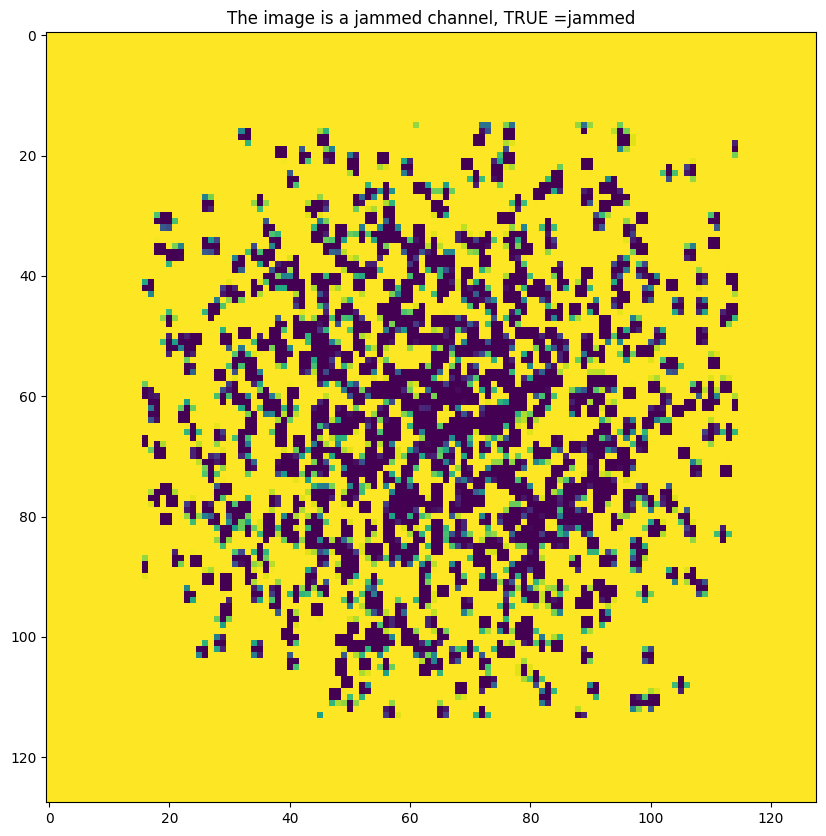

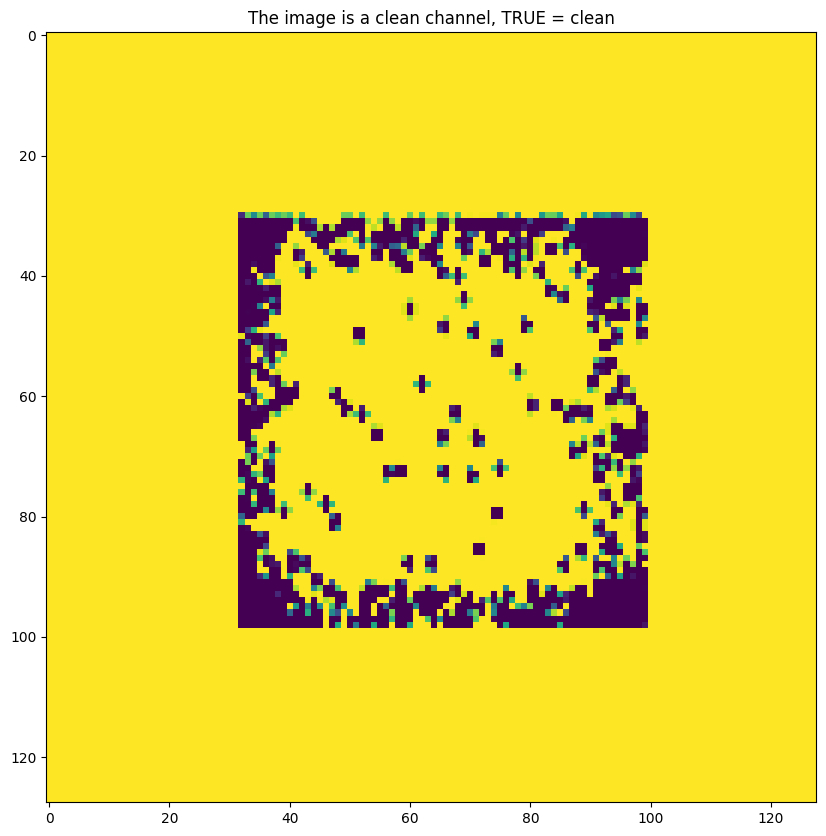

In [18]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [19]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [24]:
values_th=np.arange(normal_values[0],jammed_values[0],0.0005)
print(len(values_th))

84


In [21]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0042


  0%|          | 2/800 [00:00<01:08, 11.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0158


  0%|          | 4/800 [00:00<01:00, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0527


  1%|          | 6/800 [00:00<01:01, 13.01it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0042


  1%|          | 8/800 [00:00<01:03, 12.46it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0539


  1%|▏         | 10/800 [00:00<01:11, 10.97it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0526


  2%|▏         | 12/800 [00:01<01:15, 10.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0534


  2%|▏         | 14/800 [00:01<01:18, 10.06it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0537


  2%|▏         | 16/800 [00:01<01:19,  9.86it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0042


  2%|▏         | 18/800 [00:01<01:21,  9.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0133


  2%|▏         | 19/800 [00:01<01:21,  9.59it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0540


  2%|▎         | 20/800 [00:01<01:22,  9.46it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0520


  3%|▎         | 21/800 [00:02<01:21,  9.54it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0544


  3%|▎         | 22/800 [00:02<01:21,  9.51it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0172


  3%|▎         | 23/800 [00:02<01:21,  9.57it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0177


  3%|▎         | 24/800 [00:02<01:21,  9.52it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0048


  3%|▎         | 25/800 [00:02<01:22,  9.41it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0522


  3%|▎         | 26/800 [00:02<01:21,  9.45it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0539


  3%|▎         | 27/800 [00:02<01:23,  9.22it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0171


  4%|▎         | 29/800 [00:02<01:20,  9.53it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0048


  4%|▍         | 30/800 [00:02<01:20,  9.52it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0532


  4%|▍         | 31/800 [00:03<01:22,  9.34it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0544


  4%|▍         | 32/800 [00:03<01:22,  9.29it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0043


  4%|▍         | 33/800 [00:03<01:28,  8.67it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0540


  4%|▍         | 34/800 [00:03<01:26,  8.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0526


  4%|▍         | 36/800 [00:03<01:13, 10.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0539


  5%|▍         | 38/800 [00:03<01:07, 11.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0537


  5%|▌         | 40/800 [00:03<01:04, 11.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0555


  5%|▌         | 42/800 [00:04<01:01, 12.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0049


  6%|▌         | 44/800 [00:04<00:59, 12.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0160


  6%|▌         | 46/800 [00:04<00:59, 12.70it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0534


  6%|▌         | 48/800 [00:04<00:59, 12.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


  6%|▋         | 50/800 [00:04<00:58, 12.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


  6%|▋         | 52/800 [00:04<00:58, 12.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0540


  7%|▋         | 54/800 [00:04<00:58, 12.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0538


  7%|▋         | 56/800 [00:05<00:57, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0537


  7%|▋         | 58/800 [00:05<00:56, 13.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0544


  8%|▊         | 60/800 [00:05<00:57, 12.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


  8%|▊         | 62/800 [00:05<00:56, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0538


  8%|▊         | 64/800 [00:05<00:56, 13.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0049


  8%|▊         | 66/800 [00:05<00:56, 12.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0526


  8%|▊         | 68/800 [00:06<00:55, 13.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0174


  9%|▉         | 70/800 [00:06<00:56, 12.93it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


  9%|▉         | 72/800 [00:06<00:59, 12.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


  9%|▉         | 74/800 [00:06<00:57, 12.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 10%|▉         | 76/800 [00:06<00:56, 12.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0541


 10%|▉         | 78/800 [00:06<00:55, 13.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0528


 10%|█         | 80/800 [00:07<00:58, 12.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0450


 10%|█         | 82/800 [00:07<00:56, 12.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0537


 10%|█         | 84/800 [00:07<00:56, 12.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0526


 11%|█         | 86/800 [00:07<00:55, 12.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0043


 11%|█         | 88/800 [00:07<00:54, 13.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0453


 11%|█▏        | 90/800 [00:07<00:54, 13.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 12%|█▏        | 92/800 [00:07<00:55, 12.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0473


 12%|█▏        | 94/800 [00:08<00:55, 12.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0175


 12%|█▏        | 96/800 [00:08<00:55, 12.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


 12%|█▏        | 98/800 [00:08<00:58, 11.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0048


 12%|█▎        | 100/800 [00:08<00:56, 12.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0536


 13%|█▎        | 102/800 [00:08<00:55, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 13%|█▎        | 104/800 [00:08<00:54, 12.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0526


 13%|█▎        | 106/800 [00:09<00:55, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0535


 14%|█▎        | 108/800 [00:09<00:54, 12.78it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0540


 14%|█▍        | 110/800 [00:09<00:53, 12.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0525


 14%|█▍        | 112/800 [00:09<00:54, 12.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0537


 14%|█▍        | 114/800 [00:09<00:55, 12.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0466


 14%|█▍        | 116/800 [00:09<00:53, 12.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0538


 15%|█▍        | 118/800 [00:10<00:54, 12.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 15%|█▌        | 120/800 [00:10<00:53, 12.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 15%|█▌        | 122/800 [00:10<00:52, 12.88it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0154


 16%|█▌        | 124/800 [00:10<00:52, 12.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0546


 16%|█▌        | 126/800 [00:10<00:53, 12.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0478


 16%|█▌        | 128/800 [00:10<00:52, 12.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 16%|█▋        | 130/800 [00:10<00:54, 12.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0526


 16%|█▋        | 132/800 [00:11<00:54, 12.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 17%|█▋        | 134/800 [00:11<00:53, 12.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0542


 17%|█▋        | 136/800 [00:11<00:53, 12.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0518


 17%|█▋        | 138/800 [00:11<00:53, 12.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0539


 18%|█▊        | 140/800 [00:11<00:52, 12.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0525


 18%|█▊        | 142/800 [00:11<00:52, 12.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0524


 18%|█▊        | 144/800 [00:12<00:51, 12.69it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 18%|█▊        | 146/800 [00:12<00:50, 12.88it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0153


 18%|█▊        | 148/800 [00:12<00:52, 12.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0533


 19%|█▉        | 150/800 [00:12<00:52, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0546


 19%|█▉        | 152/800 [00:12<00:51, 12.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0528


 19%|█▉        | 154/800 [00:12<00:50, 12.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0156


 20%|█▉        | 156/800 [00:13<00:51, 12.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0540


 20%|█▉        | 158/800 [00:13<00:50, 12.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0530


 20%|██        | 160/800 [00:13<00:50, 12.58it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0176


 20%|██        | 162/800 [00:13<00:51, 12.43it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 20%|██        | 164/800 [00:13<00:56, 11.17it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0544


 21%|██        | 166/800 [00:13<00:59, 10.63it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0047


 21%|██        | 168/800 [00:14<01:01, 10.35it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0048


 21%|██▏       | 170/800 [00:14<01:02, 10.11it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0153


 22%|██▏       | 172/800 [00:14<01:02,  9.98it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0534


 22%|██▏       | 174/800 [00:14<01:04,  9.67it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0042


 22%|██▏       | 175/800 [00:14<01:05,  9.55it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0536


 22%|██▏       | 176/800 [00:15<01:05,  9.52it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0532


 22%|██▏       | 178/800 [00:15<01:02,  9.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0167


 22%|██▎       | 180/800 [00:15<01:02,  9.94it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0529


 23%|██▎       | 181/800 [00:15<01:04,  9.63it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0042


 23%|██▎       | 182/800 [00:15<01:04,  9.51it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0155


 23%|██▎       | 183/800 [00:15<01:05,  9.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0530


 23%|██▎       | 184/800 [00:15<01:06,  9.27it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0529


 23%|██▎       | 185/800 [00:15<01:06,  9.30it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0049


 23%|██▎       | 186/800 [00:16<01:06,  9.30it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0047


 23%|██▎       | 187/800 [00:16<01:04,  9.45it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0530


 24%|██▎       | 188/800 [00:16<01:04,  9.53it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0514


 24%|██▎       | 189/800 [00:16<01:04,  9.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0189


 24%|██▍       | 191/800 [00:16<00:56, 10.83it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0129


 24%|██▍       | 193/800 [00:16<00:52, 11.46it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 24%|██▍       | 195/800 [00:16<00:51, 11.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0047


 25%|██▍       | 197/800 [00:16<00:49, 12.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0536


 25%|██▍       | 199/800 [00:17<00:49, 12.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 25%|██▌       | 201/800 [00:17<00:48, 12.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 25%|██▌       | 203/800 [00:17<00:49, 11.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0538


 26%|██▌       | 205/800 [00:17<00:48, 12.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0535


 26%|██▌       | 207/800 [00:17<00:48, 12.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0541


 26%|██▌       | 209/800 [00:17<00:47, 12.33it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0154


 26%|██▋       | 211/800 [00:18<00:47, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0534


 27%|██▋       | 213/800 [00:18<00:46, 12.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0163


 27%|██▋       | 215/800 [00:18<00:46, 12.50it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0189


 27%|██▋       | 217/800 [00:18<00:47, 12.39it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0536


 27%|██▋       | 219/800 [00:18<00:47, 12.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0531


 28%|██▊       | 221/800 [00:18<00:46, 12.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0047


 28%|██▊       | 223/800 [00:19<00:46, 12.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0177


 28%|██▊       | 225/800 [00:19<00:46, 12.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0537


 28%|██▊       | 227/800 [00:19<00:45, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 29%|██▊       | 229/800 [00:19<00:45, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0174


 29%|██▉       | 231/800 [00:19<00:45, 12.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0532


 29%|██▉       | 233/800 [00:19<00:45, 12.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 29%|██▉       | 235/800 [00:20<00:45, 12.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0519


 30%|██▉       | 237/800 [00:20<00:44, 12.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0152


 30%|██▉       | 239/800 [00:20<00:44, 12.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0159


 30%|███       | 241/800 [00:20<00:43, 12.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0550


 30%|███       | 243/800 [00:20<00:43, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0047


 31%|███       | 245/800 [00:20<00:43, 12.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 31%|███       | 247/800 [00:20<00:42, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


 31%|███       | 249/800 [00:21<00:42, 12.86it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0533


 31%|███▏      | 251/800 [00:21<00:42, 12.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0531


 32%|███▏      | 253/800 [00:21<00:41, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 32%|███▏      | 255/800 [00:21<00:42, 12.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 32%|███▏      | 257/800 [00:21<00:42, 12.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0166


 32%|███▏      | 259/800 [00:21<00:43, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0175


 33%|███▎      | 261/800 [00:22<00:44, 12.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0535


 33%|███▎      | 263/800 [00:22<00:43, 12.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0526


 33%|███▎      | 265/800 [00:22<00:43, 12.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0533


 33%|███▎      | 267/800 [00:22<00:42, 12.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 34%|███▎      | 269/800 [00:22<00:42, 12.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0523


 34%|███▍      | 271/800 [00:22<00:42, 12.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0191


 34%|███▍      | 273/800 [00:23<00:42, 12.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0169


 34%|███▍      | 275/800 [00:23<00:42, 12.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0175


 35%|███▍      | 277/800 [00:23<00:42, 12.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0524


 35%|███▍      | 279/800 [00:23<00:41, 12.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0048


 35%|███▌      | 281/800 [00:23<00:40, 12.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0042


 35%|███▌      | 283/800 [00:23<00:40, 12.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0535


 36%|███▌      | 285/800 [00:24<00:42, 12.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 36%|███▌      | 287/800 [00:24<00:41, 12.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 36%|███▌      | 289/800 [00:24<00:41, 12.46it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 36%|███▋      | 291/800 [00:24<00:41, 12.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0530


 37%|███▋      | 293/800 [00:24<00:40, 12.39it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 37%|███▋      | 295/800 [00:24<00:41, 12.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0196


 37%|███▋      | 297/800 [00:25<00:41, 12.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0194


 37%|███▋      | 299/800 [00:25<00:41, 12.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 38%|███▊      | 301/800 [00:25<00:40, 12.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0529


 38%|███▊      | 303/800 [00:25<00:40, 12.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0524


 38%|███▊      | 305/800 [00:25<00:40, 12.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 38%|███▊      | 307/800 [00:25<00:39, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0527


 39%|███▊      | 309/800 [00:25<00:40, 12.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0540


 39%|███▉      | 311/800 [00:26<00:39, 12.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 39%|███▉      | 313/800 [00:26<00:39, 12.20it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0538


 39%|███▉      | 315/800 [00:26<00:41, 11.59it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0530


 40%|███▉      | 317/800 [00:26<00:45, 10.64it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0536


 40%|███▉      | 319/800 [00:26<00:47, 10.05it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 40%|████      | 321/800 [00:27<00:48,  9.82it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 40%|████      | 322/800 [00:27<00:48,  9.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0523


 40%|████      | 323/800 [00:27<00:49,  9.68it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0167


 40%|████      | 324/800 [00:27<00:50,  9.43it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0143


 41%|████      | 325/800 [00:27<00:51,  9.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0047


 41%|████      | 326/800 [00:27<00:50,  9.41it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0533


 41%|████      | 327/800 [00:27<00:51,  9.15it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0531


 41%|████      | 328/800 [00:27<00:53,  8.75it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0042


 41%|████      | 329/800 [00:28<00:57,  8.21it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0148


 41%|████▏     | 330/800 [00:28<00:57,  8.24it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0184


 41%|████▏     | 331/800 [00:28<00:54,  8.56it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0550


 42%|████▏     | 332/800 [00:28<00:53,  8.79it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0174


 42%|████▏     | 333/800 [00:28<00:51,  9.06it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0540


 42%|████▏     | 334/800 [00:28<00:50,  9.20it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0176


 42%|████▏     | 335/800 [00:28<00:49,  9.41it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0525


 42%|████▏     | 336/800 [00:28<00:51,  9.01it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0532


 42%|████▏     | 337/800 [00:28<00:52,  8.88it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0172


 42%|████▏     | 338/800 [00:29<00:54,  8.52it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0509


 42%|████▏     | 339/800 [00:29<00:53,  8.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0160


 42%|████▎     | 340/800 [00:29<00:51,  9.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0532


 43%|████▎     | 342/800 [00:29<00:45, 10.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 43%|████▎     | 344/800 [00:29<00:41, 10.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0530


 43%|████▎     | 346/800 [00:29<00:39, 11.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0536


 44%|████▎     | 348/800 [00:29<00:38, 11.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0175


 44%|████▍     | 350/800 [00:30<00:38, 11.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0533


 44%|████▍     | 352/800 [00:30<00:36, 12.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0512


 44%|████▍     | 354/800 [00:30<00:36, 12.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0542


 44%|████▍     | 356/800 [00:30<00:36, 12.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0446


 45%|████▍     | 358/800 [00:30<00:36, 12.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0042


 45%|████▌     | 360/800 [00:30<00:35, 12.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0049


 45%|████▌     | 362/800 [00:31<00:36, 11.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0535


 46%|████▌     | 364/800 [00:31<00:36, 12.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0442


 46%|████▌     | 366/800 [00:31<00:35, 12.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0152


 46%|████▌     | 368/800 [00:31<00:34, 12.37it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0144


 46%|████▋     | 370/800 [00:31<00:34, 12.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0534


 46%|████▋     | 372/800 [00:31<00:34, 12.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0541


 47%|████▋     | 374/800 [00:32<00:35, 12.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0164


 47%|████▋     | 376/800 [00:32<00:35, 11.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0520


 47%|████▋     | 378/800 [00:32<00:34, 12.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0536


 48%|████▊     | 380/800 [00:32<00:34, 12.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 48%|████▊     | 382/800 [00:32<00:34, 12.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0048


 48%|████▊     | 384/800 [00:32<00:34, 12.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 48%|████▊     | 386/800 [00:33<00:33, 12.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 48%|████▊     | 388/800 [00:33<00:33, 12.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 49%|████▉     | 390/800 [00:33<00:33, 12.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0535


 49%|████▉     | 392/800 [00:33<00:33, 12.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 49%|████▉     | 394/800 [00:33<00:32, 12.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0453


 50%|████▉     | 396/800 [00:33<00:32, 12.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 50%|████▉     | 398/800 [00:34<00:32, 12.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0048


 50%|█████     | 400/800 [00:34<00:33, 11.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 50%|█████     | 402/800 [00:34<00:33, 12.05it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 50%|█████     | 404/800 [00:34<00:32, 12.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0540


 51%|█████     | 406/800 [00:34<00:32, 12.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0459


 51%|█████     | 408/800 [00:34<00:32, 12.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 51%|█████▏    | 410/800 [00:35<00:31, 12.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 52%|█████▏    | 412/800 [00:35<00:31, 12.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0161


 52%|█████▏    | 414/800 [00:35<00:31, 12.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0533


 52%|█████▏    | 416/800 [00:35<00:31, 12.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0049


 52%|█████▏    | 418/800 [00:35<00:30, 12.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0152


 52%|█████▎    | 420/800 [00:35<00:30, 12.43it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0540


 53%|█████▎    | 422/800 [00:36<00:30, 12.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0528


 53%|█████▎    | 424/800 [00:36<00:30, 12.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0534


 53%|█████▎    | 426/800 [00:36<00:30, 12.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 54%|█████▎    | 428/800 [00:36<00:29, 12.45it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0526


 54%|█████▍    | 430/800 [00:36<00:29, 12.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0048


 54%|█████▍    | 432/800 [00:36<00:29, 12.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0545


 54%|█████▍    | 434/800 [00:36<00:29, 12.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0527


 55%|█████▍    | 436/800 [00:37<00:29, 12.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0533


 55%|█████▍    | 438/800 [00:37<00:29, 12.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0519


 55%|█████▌    | 440/800 [00:37<00:28, 12.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 55%|█████▌    | 442/800 [00:37<00:29, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0163


 56%|█████▌    | 444/800 [00:37<00:28, 12.28it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 56%|█████▌    | 446/800 [00:37<00:28, 12.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0449


 56%|█████▌    | 448/800 [00:38<00:28, 12.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0181


 56%|█████▋    | 450/800 [00:38<00:28, 12.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0542


 56%|█████▋    | 452/800 [00:38<00:28, 12.12it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0049


 57%|█████▋    | 454/800 [00:38<00:29, 11.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 57%|█████▋    | 456/800 [00:38<00:29, 11.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0537


 57%|█████▋    | 458/800 [00:38<00:29, 11.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0538


 57%|█████▊    | 460/800 [00:39<00:27, 12.17it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0180


 58%|█████▊    | 462/800 [00:39<00:27, 12.14it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0180


 58%|█████▊    | 464/800 [00:39<00:29, 11.58it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0526


 58%|█████▊    | 466/800 [00:39<00:30, 10.87it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0042


 58%|█████▊    | 468/800 [00:39<00:32, 10.16it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0533


 59%|█████▉    | 470/800 [00:40<00:33,  9.75it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0534


 59%|█████▉    | 471/800 [00:40<00:34,  9.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0546


 59%|█████▉    | 472/800 [00:40<00:34,  9.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0551


 59%|█████▉    | 474/800 [00:40<00:33,  9.63it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0528


 59%|█████▉    | 475/800 [00:40<00:33,  9.61it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0178


 60%|█████▉    | 476/800 [00:40<00:35,  9.25it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0531


 60%|█████▉    | 477/800 [00:40<00:35,  9.02it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0537


 60%|█████▉    | 478/800 [00:41<00:35,  9.02it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0156


 60%|█████▉    | 479/800 [00:41<00:35,  8.99it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0535


 60%|██████    | 480/800 [00:41<00:35,  8.97it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0536


 60%|██████    | 481/800 [00:41<00:35,  8.93it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0533


 60%|██████    | 482/800 [00:41<00:35,  8.98it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0154


 60%|██████    | 483/800 [00:41<00:35,  8.97it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0520


 60%|██████    | 484/800 [00:41<00:34,  9.09it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0526


 61%|██████    | 485/800 [00:41<00:33,  9.29it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0155


 61%|██████    | 486/800 [00:41<00:34,  9.16it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0528


 61%|██████    | 487/800 [00:42<00:34,  9.05it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0529


 61%|██████    | 488/800 [00:42<00:35,  8.71it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0533


 61%|██████    | 489/800 [00:42<00:35,  8.68it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0462


 61%|██████▏   | 490/800 [00:42<00:35,  8.75it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0048


 61%|██████▏   | 491/800 [00:42<00:35,  8.74it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0049


 62%|██████▏   | 492/800 [00:42<00:34,  8.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 62%|██████▏   | 494/800 [00:42<00:30, 10.13it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0141


 62%|██████▏   | 496/800 [00:42<00:28, 10.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0168


 62%|██████▏   | 498/800 [00:43<00:26, 11.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0147


 62%|██████▎   | 500/800 [00:43<00:25, 11.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 63%|██████▎   | 502/800 [00:43<00:25, 11.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0044


 63%|██████▎   | 504/800 [00:43<00:24, 12.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0463


 63%|██████▎   | 506/800 [00:43<00:24, 12.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0525


 64%|██████▎   | 508/800 [00:43<00:23, 12.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0529


 64%|██████▍   | 510/800 [00:44<00:23, 12.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 64%|██████▍   | 512/800 [00:44<00:23, 12.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0532


 64%|██████▍   | 514/800 [00:44<00:23, 12.08it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 64%|██████▍   | 516/800 [00:44<00:23, 11.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0538


 65%|██████▍   | 518/800 [00:44<00:23, 11.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0524


 65%|██████▌   | 520/800 [00:44<00:23, 11.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 65%|██████▌   | 522/800 [00:45<00:23, 11.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0159


 66%|██████▌   | 524/800 [00:45<00:23, 11.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0153


 66%|██████▌   | 526/800 [00:45<00:22, 11.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 66%|██████▌   | 528/800 [00:45<00:23, 11.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 66%|██████▋   | 530/800 [00:45<00:22, 12.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0174


 66%|██████▋   | 532/800 [00:45<00:22, 12.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 67%|██████▋   | 534/800 [00:46<00:21, 12.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 67%|██████▋   | 536/800 [00:46<00:21, 12.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0543


 67%|██████▋   | 538/800 [00:46<00:21, 12.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0539


 68%|██████▊   | 540/800 [00:46<00:21, 12.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 68%|██████▊   | 542/800 [00:46<00:21, 11.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0527


 68%|██████▊   | 544/800 [00:46<00:21, 11.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0527


 68%|██████▊   | 546/800 [00:47<00:20, 12.13it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0177


 68%|██████▊   | 548/800 [00:47<00:35,  7.19it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0520


 69%|██████▉   | 550/800 [00:47<00:30,  8.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0537


 69%|██████▉   | 552/800 [00:47<00:27,  8.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 69%|██████▉   | 554/800 [00:48<00:25,  9.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0535


 70%|██████▉   | 556/800 [00:48<00:24, 10.00it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 70%|██████▉   | 558/800 [00:48<00:23, 10.44it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 70%|███████   | 560/800 [00:48<00:22, 10.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0531


 70%|███████   | 562/800 [00:48<00:21, 11.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0048


 70%|███████   | 564/800 [00:48<00:20, 11.60it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0174


 71%|███████   | 566/800 [00:49<00:19, 11.81it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0042


 71%|███████   | 568/800 [00:49<00:19, 11.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0144


 71%|███████▏  | 570/800 [00:49<00:18, 12.11it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0174


 72%|███████▏  | 572/800 [00:49<00:19, 11.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 72%|███████▏  | 574/800 [00:49<00:18, 12.30it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 72%|███████▏  | 576/800 [00:49<00:18, 12.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0169


 72%|███████▏  | 578/800 [00:50<00:17, 12.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0453


 72%|███████▎  | 580/800 [00:50<00:17, 12.43it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 73%|███████▎  | 582/800 [00:50<00:17, 12.17it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0539


 73%|███████▎  | 584/800 [00:50<00:18, 11.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0523


 73%|███████▎  | 586/800 [00:50<00:18, 11.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0047


 74%|███████▎  | 588/800 [00:50<00:18, 11.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0472


 74%|███████▍  | 590/800 [00:51<00:18, 11.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0522


 74%|███████▍  | 592/800 [00:51<00:18, 11.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0540


 74%|███████▍  | 594/800 [00:51<00:18, 11.39it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0525


 74%|███████▍  | 596/800 [00:51<00:18, 11.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0547


 75%|███████▍  | 598/800 [00:51<00:18, 11.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0524


 75%|███████▌  | 600/800 [00:52<00:18, 11.03it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0535


 75%|███████▌  | 602/800 [00:52<00:17, 11.13it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0173


 76%|███████▌  | 604/800 [00:52<00:17, 11.07it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0536


 76%|███████▌  | 606/800 [00:52<00:17, 10.81it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0527


 76%|███████▌  | 608/800 [00:52<00:20,  9.52it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0540


 76%|███████▌  | 609/800 [00:52<00:20,  9.12it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0184


 76%|███████▋  | 610/800 [00:53<00:21,  8.94it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0042


 76%|███████▋  | 611/800 [00:53<00:21,  8.77it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0047


 76%|███████▋  | 612/800 [00:53<00:21,  8.79it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0048


 77%|███████▋  | 613/800 [00:53<00:20,  8.97it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0524


 77%|███████▋  | 614/800 [00:53<00:21,  8.82it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0179


 77%|███████▋  | 615/800 [00:53<00:21,  8.66it/s]

1/1 [==============================] - 0s 59ms/step - loss: 0.0543


 77%|███████▋  | 616/800 [00:53<00:22,  8.24it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0169


 77%|███████▋  | 617/800 [00:53<00:21,  8.47it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0154


 77%|███████▋  | 618/800 [00:54<00:24,  7.50it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0524


 77%|███████▋  | 619/800 [00:54<00:23,  7.80it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0527


 78%|███████▊  | 620/800 [00:54<00:22,  7.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0521


 78%|███████▊  | 621/800 [00:54<00:21,  8.33it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0188


 78%|███████▊  | 622/800 [00:54<00:21,  8.19it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0048


 78%|███████▊  | 623/800 [00:54<00:21,  8.05it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0042


 78%|███████▊  | 624/800 [00:54<00:21,  8.09it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0042


 78%|███████▊  | 625/800 [00:54<00:21,  8.09it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0155


 78%|███████▊  | 626/800 [00:55<00:21,  8.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 78%|███████▊  | 627/800 [00:55<00:20,  8.48it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0528


 78%|███████▊  | 628/800 [00:55<00:20,  8.58it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0527


 79%|███████▊  | 629/800 [00:55<00:20,  8.43it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0531


 79%|███████▉  | 630/800 [00:55<00:20,  8.38it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0443


 79%|███████▉  | 631/800 [00:55<00:20,  8.40it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0524


 79%|███████▉  | 633/800 [00:55<00:18,  9.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0535


 79%|███████▉  | 635/800 [00:56<00:16, 10.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 80%|███████▉  | 637/800 [00:56<00:15, 10.70it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0537


 80%|███████▉  | 639/800 [00:56<00:14, 11.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0178


 80%|████████  | 641/800 [00:56<00:14, 11.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0536


 80%|████████  | 643/800 [00:56<00:13, 11.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 81%|████████  | 645/800 [00:56<00:13, 11.53it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 81%|████████  | 647/800 [00:57<00:13, 11.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 81%|████████  | 649/800 [00:57<00:12, 11.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 81%|████████▏ | 651/800 [00:57<00:12, 11.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0543


 82%|████████▏ | 653/800 [00:57<00:12, 11.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 82%|████████▏ | 655/800 [00:57<00:12, 11.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 82%|████████▏ | 657/800 [00:57<00:12, 11.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0175


 82%|████████▏ | 659/800 [00:58<00:11, 11.94it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 83%|████████▎ | 661/800 [00:58<00:11, 11.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0525


 83%|████████▎ | 663/800 [00:58<00:11, 11.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0536


 83%|████████▎ | 665/800 [00:58<00:11, 11.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0157


 83%|████████▎ | 667/800 [00:58<00:11, 12.03it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0510


 84%|████████▎ | 669/800 [00:58<00:11, 11.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0529


 84%|████████▍ | 671/800 [00:59<00:10, 12.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0165


 84%|████████▍ | 673/800 [00:59<00:10, 11.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0172


 84%|████████▍ | 675/800 [00:59<00:10, 12.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0174


 85%|████████▍ | 677/800 [00:59<00:10, 12.12it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0529


 85%|████████▍ | 679/800 [00:59<00:09, 12.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0538


 85%|████████▌ | 681/800 [00:59<00:09, 12.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0548


 85%|████████▌ | 683/800 [01:00<00:10, 11.17it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0537


 86%|████████▌ | 685/800 [01:00<00:10, 11.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0524


 86%|████████▌ | 687/800 [01:00<00:09, 11.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 86%|████████▌ | 689/800 [01:00<00:09, 11.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0166


 86%|████████▋ | 691/800 [01:00<00:09, 11.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0527


 87%|████████▋ | 693/800 [01:00<00:09, 11.68it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0550


 87%|████████▋ | 695/800 [01:01<00:08, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0192


 87%|████████▋ | 697/800 [01:01<00:08, 11.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 87%|████████▋ | 699/800 [01:01<00:08, 11.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0533


 88%|████████▊ | 701/800 [01:01<00:08, 12.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 88%|████████▊ | 703/800 [01:01<00:08, 12.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0178


 88%|████████▊ | 705/800 [01:01<00:08, 11.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0162


 88%|████████▊ | 707/800 [01:02<00:07, 11.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0525


 89%|████████▊ | 709/800 [01:02<00:07, 11.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 89%|████████▉ | 711/800 [01:02<00:07, 11.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0522


 89%|████████▉ | 713/800 [01:02<00:07, 12.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0543


 89%|████████▉ | 715/800 [01:02<00:07, 12.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0527


 90%|████████▉ | 717/800 [01:02<00:06, 12.01it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0528


 90%|████████▉ | 719/800 [01:03<00:06, 11.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0131


 90%|█████████ | 721/800 [01:03<00:06, 11.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0529


 90%|█████████ | 723/800 [01:03<00:06, 11.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0540


 91%|█████████ | 725/800 [01:03<00:06, 12.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0155


 91%|█████████ | 727/800 [01:03<00:06, 12.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 91%|█████████ | 729/800 [01:03<00:05, 12.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0049


 91%|█████████▏| 731/800 [01:04<00:05, 11.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0047


 92%|█████████▏| 733/800 [01:04<00:05, 12.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0159


 92%|█████████▏| 735/800 [01:04<00:05, 11.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 92%|█████████▏| 737/800 [01:04<00:05, 11.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0523


 92%|█████████▏| 739/800 [01:04<00:05, 11.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0532


 93%|█████████▎| 741/800 [01:04<00:04, 11.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 93%|█████████▎| 743/800 [01:05<00:04, 11.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 93%|█████████▎| 745/800 [01:05<00:04, 11.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0542


 93%|█████████▎| 747/800 [01:05<00:04, 11.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0534


 94%|█████████▎| 749/800 [01:05<00:04, 11.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0534


 94%|█████████▍| 751/800 [01:05<00:04, 11.56it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0175


 94%|█████████▍| 753/800 [01:06<00:04, 10.63it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0530


 94%|█████████▍| 755/800 [01:06<00:04, 10.13it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0177


 95%|█████████▍| 757/800 [01:06<00:04,  9.93it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0042


 95%|█████████▍| 759/800 [01:06<00:04,  9.97it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0543


 95%|█████████▌| 761/800 [01:06<00:03,  9.92it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0156


 95%|█████████▌| 762/800 [01:06<00:03,  9.62it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0536


 95%|█████████▌| 763/800 [01:07<00:04,  8.37it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 96%|█████████▌| 764/800 [01:07<00:04,  8.33it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0042


 96%|█████████▌| 765/800 [01:07<00:04,  8.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0530


 96%|█████████▌| 766/800 [01:07<00:04,  8.27it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0181


 96%|█████████▌| 767/800 [01:07<00:03,  8.61it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0525


 96%|█████████▌| 768/800 [01:07<00:03,  8.44it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 96%|█████████▌| 769/800 [01:07<00:03,  8.38it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 96%|█████████▋| 770/800 [01:07<00:03,  8.57it/s]

1/1 [==============================] - 0s 61ms/step - loss: 0.0529


 96%|█████████▋| 771/800 [01:08<00:03,  8.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0049


 97%|█████████▋| 773/800 [01:08<00:03,  8.98it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0042


 97%|█████████▋| 774/800 [01:08<00:02,  8.99it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0184


 97%|█████████▋| 775/800 [01:08<00:03,  7.93it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0528


 97%|█████████▋| 776/800 [01:08<00:02,  8.14it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0154


 97%|█████████▋| 777/800 [01:08<00:02,  8.06it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0047


 97%|█████████▋| 778/800 [01:08<00:02,  7.91it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0530


 97%|█████████▋| 779/800 [01:09<00:02,  8.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0049


 98%|█████████▊| 780/800 [01:09<00:02,  8.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0169


 98%|█████████▊| 782/800 [01:09<00:01,  9.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0178


 98%|█████████▊| 784/800 [01:09<00:01, 10.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0537


 98%|█████████▊| 786/800 [01:09<00:01, 10.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


 98%|█████████▊| 788/800 [01:09<00:01, 11.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0183


 99%|█████████▉| 790/800 [01:10<00:00, 11.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0177


 99%|█████████▉| 792/800 [01:10<00:00, 11.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0528


 99%|█████████▉| 794/800 [01:10<00:00, 11.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


100%|█████████▉| 796/800 [01:10<00:00, 11.80it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0174


100%|█████████▉| 798/800 [01:10<00:00, 11.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0049


100%|██████████| 800/800 [01:10<00:00, 11.28it/s]

800


In [25]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [26]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [27]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00375, 0.00625, 0.015, 0.0175, 0.0275, 0.03, 0.0325, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.04375, 0.05, 0.09375]
[0.25, 0.25, 0.25, 0.25, 0.25, 0.245, 0.24375, 0.24, 0.2325, 0.21625, 0.18625, 0.16375, 0.1475, 0.12625, 0.07375, 0.03875, 0.0125, 0.0025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


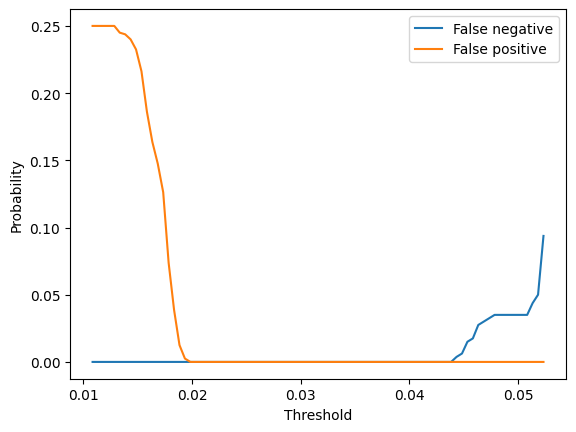

In [28]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [29]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


  0%|          | 2/800 [00:00<00:58, 13.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0158


  0%|          | 4/800 [00:00<01:00, 13.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


  1%|          | 6/800 [00:00<00:59, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


  1%|          | 8/800 [00:00<00:58, 13.52it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0539


  1%|▏         | 10/800 [00:00<00:59, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0526


  2%|▏         | 12/800 [00:00<01:00, 12.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0534


  2%|▏         | 14/800 [00:01<01:00, 12.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0537


  2%|▏         | 16/800 [00:01<01:02, 12.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


  2%|▏         | 18/800 [00:01<01:00, 12.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0540


  2%|▎         | 20/800 [00:01<01:02, 12.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0544


  3%|▎         | 22/800 [00:01<01:02, 12.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0177


  3%|▎         | 24/800 [00:01<01:00, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0522


  3%|▎         | 26/800 [00:02<00:59, 13.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0157


  4%|▎         | 28/800 [00:02<00:59, 13.03it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0048


  4%|▍         | 30/800 [00:02<01:01, 12.55it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0544


  4%|▍         | 32/800 [00:02<01:11, 10.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0540


  4%|▍         | 34/800 [00:02<01:13, 10.44it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0526


  4%|▍         | 36/800 [00:02<01:14, 10.21it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0539


  5%|▍         | 38/800 [00:03<01:17,  9.81it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0537


  5%|▌         | 40/800 [00:03<01:18,  9.63it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0555


  5%|▌         | 42/800 [00:03<01:18,  9.67it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0536


  5%|▌         | 43/800 [00:03<01:18,  9.66it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0177


  6%|▌         | 45/800 [00:03<01:17,  9.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0160


  6%|▌         | 46/800 [00:04<01:18,  9.66it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0171


  6%|▌         | 47/800 [00:04<01:18,  9.58it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0534


  6%|▌         | 48/800 [00:04<01:20,  9.39it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0541


  6%|▌         | 49/800 [00:04<01:21,  9.25it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0042


  6%|▋         | 50/800 [00:04<01:19,  9.40it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0049


  6%|▋         | 51/800 [00:04<01:19,  9.37it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


  6%|▋         | 52/800 [00:04<01:20,  9.27it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0517


  7%|▋         | 53/800 [00:04<01:20,  9.31it/s]

1/1 [==============================] - 0s 52ms/step - loss: 0.0540


  7%|▋         | 54/800 [00:04<01:22,  9.05it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0443


  7%|▋         | 55/800 [00:05<01:23,  8.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


  7%|▋         | 57/800 [00:05<01:12, 10.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0159


  7%|▋         | 59/800 [00:05<01:06, 11.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


  8%|▊         | 61/800 [00:05<01:04, 11.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0175


  8%|▊         | 63/800 [00:05<01:02, 11.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


  8%|▊         | 65/800 [00:05<00:59, 12.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0533


  8%|▊         | 67/800 [00:05<00:59, 12.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


  9%|▊         | 69/800 [00:06<00:57, 12.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0544


  9%|▉         | 71/800 [00:06<00:57, 12.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


  9%|▉         | 73/800 [00:06<00:58, 12.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0527


  9%|▉         | 75/800 [00:06<00:56, 12.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0163


 10%|▉         | 77/800 [00:06<00:57, 12.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0530


 10%|▉         | 79/800 [00:06<00:56, 12.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0540


 10%|█         | 81/800 [00:07<00:57, 12.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0543


 10%|█         | 83/800 [00:07<00:57, 12.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0459


 11%|█         | 85/800 [00:07<00:57, 12.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 11%|█         | 87/800 [00:07<00:56, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 11%|█         | 89/800 [00:07<00:56, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0538


 11%|█▏        | 91/800 [00:07<00:56, 12.66it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0537


 12%|█▏        | 93/800 [00:08<00:58, 12.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0159


 12%|█▏        | 95/800 [00:08<00:57, 12.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0532


 12%|█▏        | 97/800 [00:08<00:56, 12.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0522


 12%|█▏        | 99/800 [00:08<00:54, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 13%|█▎        | 101/800 [00:08<00:54, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0171


 13%|█▎        | 103/800 [00:08<00:55, 12.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0049


 13%|█▎        | 105/800 [00:09<00:54, 12.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0050


 13%|█▎        | 107/800 [00:09<00:55, 12.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0510


 14%|█▎        | 109/800 [00:09<00:54, 12.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0532


 14%|█▍        | 111/800 [00:09<00:54, 12.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0549


 14%|█▍        | 113/800 [00:09<00:54, 12.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0520


 14%|█▍        | 115/800 [00:09<00:54, 12.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0530


 15%|█▍        | 117/800 [00:09<00:55, 12.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0550


 15%|█▍        | 119/800 [00:10<00:55, 12.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0528


 15%|█▌        | 121/800 [00:10<00:54, 12.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0537


 15%|█▌        | 123/800 [00:10<00:53, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0541


 16%|█▌        | 125/800 [00:10<00:53, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0531


 16%|█▌        | 127/800 [00:10<00:53, 12.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0521


 16%|█▌        | 129/800 [00:10<00:53, 12.52it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0537


 16%|█▋        | 131/800 [00:11<00:52, 12.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0446


 17%|█▋        | 133/800 [00:11<00:53, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0150


 17%|█▋        | 135/800 [00:11<00:52, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 17%|█▋        | 137/800 [00:11<00:53, 12.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0049


 17%|█▋        | 139/800 [00:11<00:53, 12.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0522


 18%|█▊        | 141/800 [00:11<00:52, 12.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 18%|█▊        | 143/800 [00:12<00:51, 12.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0547


 18%|█▊        | 145/800 [00:12<00:53, 12.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0476


 18%|█▊        | 147/800 [00:12<00:54, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0166


 19%|█▊        | 149/800 [00:12<00:52, 12.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0172


 19%|█▉        | 151/800 [00:12<00:51, 12.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0529


 19%|█▉        | 153/800 [00:12<00:50, 12.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 19%|█▉        | 155/800 [00:12<00:49, 13.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 20%|█▉        | 157/800 [00:13<00:49, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 20%|█▉        | 159/800 [00:13<00:50, 12.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 20%|██        | 161/800 [00:13<00:50, 12.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


 20%|██        | 163/800 [00:13<00:50, 12.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0462


 21%|██        | 165/800 [00:13<00:50, 12.58it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0533


 21%|██        | 167/800 [00:13<00:50, 12.44it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 21%|██        | 169/800 [00:14<00:50, 12.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 21%|██▏       | 171/800 [00:14<00:49, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 22%|██▏       | 173/800 [00:14<00:50, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 22%|██▏       | 175/800 [00:14<00:49, 12.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 22%|██▏       | 177/800 [00:14<00:50, 12.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0153


 22%|██▏       | 179/800 [00:14<00:50, 12.39it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 23%|██▎       | 181/800 [00:15<00:48, 12.78it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0155


 23%|██▎       | 183/800 [00:15<00:53, 11.60it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0529


 23%|██▎       | 185/800 [00:15<00:58, 10.45it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0047


 23%|██▎       | 187/800 [00:15<00:59, 10.31it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0514


 24%|██▎       | 189/800 [00:15<01:00, 10.09it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0189


 24%|██▍       | 191/800 [00:16<00:59, 10.19it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0129


 24%|██▍       | 193/800 [00:16<01:02,  9.69it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0047


 24%|██▍       | 194/800 [00:16<01:03,  9.59it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0182


 24%|██▍       | 195/800 [00:16<01:03,  9.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0042


 24%|██▍       | 196/800 [00:16<01:03,  9.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0047


 25%|██▍       | 197/800 [00:16<01:03,  9.54it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0152


 25%|██▍       | 198/800 [00:16<01:03,  9.46it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0536


 25%|██▍       | 199/800 [00:16<01:04,  9.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0149


 25%|██▌       | 200/800 [00:17<01:05,  9.10it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 25%|██▌       | 201/800 [00:17<01:04,  9.24it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0521


 25%|██▌       | 202/800 [00:17<01:08,  8.77it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 25%|██▌       | 203/800 [00:17<01:06,  8.96it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0133


 26%|██▌       | 204/800 [00:17<01:05,  9.08it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0538


 26%|██▌       | 205/800 [00:17<01:05,  9.11it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0047


 26%|██▌       | 206/800 [00:17<01:03,  9.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0535


 26%|██▌       | 207/800 [00:17<01:02,  9.47it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0529


 26%|██▌       | 208/800 [00:17<01:02,  9.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0156


 26%|██▋       | 210/800 [00:18<00:54, 10.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0535


 26%|██▋       | 212/800 [00:18<00:52, 11.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0459


 27%|██▋       | 214/800 [00:18<00:51, 11.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0524


 27%|██▋       | 216/800 [00:18<00:49, 11.75it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


 27%|██▋       | 218/800 [00:18<00:47, 12.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0158


 28%|██▊       | 220/800 [00:18<00:47, 12.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0523


 28%|██▊       | 222/800 [00:19<00:45, 12.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0048


 28%|██▊       | 224/800 [00:19<00:45, 12.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 28%|██▊       | 226/800 [00:19<00:46, 12.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0530


 28%|██▊       | 228/800 [00:19<00:45, 12.51it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 29%|██▉       | 230/800 [00:19<00:45, 12.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0543


 29%|██▉       | 232/800 [00:19<00:44, 12.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0048


 29%|██▉       | 234/800 [00:20<00:44, 12.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0170


 30%|██▉       | 236/800 [00:20<00:44, 12.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 30%|██▉       | 238/800 [00:20<00:44, 12.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0539


 30%|███       | 240/800 [00:20<00:43, 12.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 30%|███       | 242/800 [00:20<00:43, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 30%|███       | 244/800 [00:20<00:43, 12.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 31%|███       | 246/800 [00:20<00:43, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0520


 31%|███       | 248/800 [00:21<00:42, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 31%|███▏      | 250/800 [00:21<00:42, 13.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0532


 32%|███▏      | 252/800 [00:21<00:43, 12.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 32%|███▏      | 254/800 [00:21<00:43, 12.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0535


 32%|███▏      | 256/800 [00:21<00:43, 12.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0156


 32%|███▏      | 258/800 [00:21<00:42, 12.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0191


 32%|███▎      | 260/800 [00:22<00:42, 12.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0521


 33%|███▎      | 262/800 [00:22<00:44, 12.20it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0528


 33%|███▎      | 264/800 [00:22<00:44, 12.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 33%|███▎      | 266/800 [00:22<00:43, 12.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0528


 34%|███▎      | 268/800 [00:22<00:43, 12.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0531


 34%|███▍      | 270/800 [00:22<00:42, 12.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 34%|███▍      | 272/800 [00:23<00:41, 12.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0544


 34%|███▍      | 274/800 [00:23<00:42, 12.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0526


 34%|███▍      | 276/800 [00:23<00:41, 12.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0530


 35%|███▍      | 278/800 [00:23<00:41, 12.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0167


 35%|███▌      | 280/800 [00:23<00:41, 12.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0537


 35%|███▌      | 282/800 [00:23<00:41, 12.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 36%|███▌      | 284/800 [00:24<00:41, 12.52it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 36%|███▌      | 286/800 [00:24<00:41, 12.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0047


 36%|███▌      | 288/800 [00:24<00:40, 12.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0151


 36%|███▋      | 290/800 [00:24<00:41, 12.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0533


 36%|███▋      | 292/800 [00:24<00:40, 12.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0539


 37%|███▋      | 294/800 [00:24<00:40, 12.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0525


 37%|███▋      | 296/800 [00:24<00:40, 12.57it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 37%|███▋      | 298/800 [00:25<00:40, 12.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0530


 38%|███▊      | 300/800 [00:25<00:40, 12.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 38%|███▊      | 302/800 [00:25<00:40, 12.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0174


 38%|███▊      | 304/800 [00:25<00:41, 12.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0453


 38%|███▊      | 306/800 [00:25<00:40, 12.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0522


 38%|███▊      | 308/800 [00:25<00:40, 12.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0528


 39%|███▉      | 310/800 [00:26<00:39, 12.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0458


 39%|███▉      | 312/800 [00:26<00:39, 12.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 39%|███▉      | 314/800 [00:26<00:38, 12.47it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0534


 40%|███▉      | 316/800 [00:26<00:40, 12.10it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0526


 40%|███▉      | 318/800 [00:26<00:39, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0530


 40%|████      | 320/800 [00:26<00:39, 12.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 40%|████      | 322/800 [00:27<00:39, 12.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0167


 40%|████      | 324/800 [00:27<00:38, 12.40it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0047


 41%|████      | 326/800 [00:27<00:38, 12.22it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0531


 41%|████      | 328/800 [00:27<00:38, 12.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0148


 41%|████▏     | 330/800 [00:27<00:38, 12.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0550


 42%|████▏     | 332/800 [00:27<00:38, 12.30it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0540


 42%|████▏     | 334/800 [00:28<00:39, 11.86it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0525


 42%|████▏     | 336/800 [00:28<00:42, 10.98it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0172


 42%|████▏     | 338/800 [00:28<00:44, 10.39it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0160


 42%|████▎     | 340/800 [00:28<00:47,  9.76it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0177


 43%|████▎     | 341/800 [00:28<00:49,  9.20it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0532


 43%|████▎     | 342/800 [00:29<00:49,  9.19it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0047


 43%|████▎     | 343/800 [00:29<00:49,  9.21it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0047


 43%|████▎     | 344/800 [00:29<00:50,  9.12it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0538


 43%|████▎     | 345/800 [00:29<00:50,  9.02it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0530


 43%|████▎     | 346/800 [00:29<00:49,  9.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0193


 43%|████▎     | 347/800 [00:29<00:48,  9.31it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0536


 44%|████▎     | 348/800 [00:29<00:48,  9.28it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0185


 44%|████▎     | 349/800 [00:29<00:50,  8.95it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0175


 44%|████▍     | 350/800 [00:29<00:50,  8.96it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0146


 44%|████▍     | 351/800 [00:30<00:50,  8.91it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0533


 44%|████▍     | 352/800 [00:30<00:50,  8.95it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0543


 44%|████▍     | 353/800 [00:30<00:49,  8.99it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0512


 44%|████▍     | 354/800 [00:30<00:49,  9.00it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0045


 44%|████▍     | 355/800 [00:30<00:49,  8.91it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0542


 44%|████▍     | 356/800 [00:30<00:49,  8.92it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0177


 45%|████▍     | 357/800 [00:30<00:51,  8.52it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0446


 45%|████▍     | 358/800 [00:30<00:51,  8.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0528


 45%|████▍     | 359/800 [00:30<00:50,  8.73it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 45%|████▌     | 361/800 [00:31<00:44,  9.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 45%|████▌     | 363/800 [00:31<00:40, 10.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0532


 46%|████▌     | 365/800 [00:31<00:38, 11.44it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 46%|████▌     | 367/800 [00:31<00:37, 11.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0534


 46%|████▌     | 369/800 [00:31<00:36, 11.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 46%|████▋     | 371/800 [00:31<00:35, 12.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0462


 47%|████▋     | 373/800 [00:32<00:34, 12.31it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0524


 47%|████▋     | 375/800 [00:32<00:34, 12.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0538


 47%|████▋     | 377/800 [00:32<00:34, 12.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0533


 47%|████▋     | 379/800 [00:32<00:34, 12.38it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0048


 48%|████▊     | 381/800 [00:32<00:33, 12.47it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0532


 48%|████▊     | 383/800 [00:32<00:33, 12.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0535


 48%|████▊     | 385/800 [00:33<00:32, 12.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0529


 48%|████▊     | 387/800 [00:33<00:32, 12.60it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0529


 49%|████▊     | 389/800 [00:33<00:32, 12.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0527


 49%|████▉     | 391/800 [00:33<00:32, 12.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 49%|████▉     | 393/800 [00:33<00:33, 12.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0048


 49%|████▉     | 395/800 [00:33<00:33, 12.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 50%|████▉     | 397/800 [00:33<00:32, 12.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0536


 50%|████▉     | 399/800 [00:34<00:32, 12.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 50%|█████     | 401/800 [00:34<00:32, 12.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0164


 50%|█████     | 403/800 [00:34<00:31, 12.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0048


 51%|█████     | 405/800 [00:34<00:31, 12.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 51%|█████     | 407/800 [00:34<00:31, 12.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 51%|█████     | 409/800 [00:34<00:32, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0521


 51%|█████▏    | 411/800 [00:35<00:34, 11.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 52%|█████▏    | 413/800 [00:35<00:33, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 52%|█████▏    | 415/800 [00:35<00:32, 11.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0542


 52%|█████▏    | 417/800 [00:35<00:31, 12.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0455


 52%|█████▏    | 419/800 [00:35<00:32, 11.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0532


 53%|█████▎    | 421/800 [00:35<00:31, 11.93it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 53%|█████▎    | 423/800 [00:36<00:31, 12.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0531


 53%|█████▎    | 425/800 [00:36<00:30, 12.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 53%|█████▎    | 427/800 [00:36<00:30, 12.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0042


 54%|█████▎    | 429/800 [00:36<00:30, 12.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0176


 54%|█████▍    | 431/800 [00:36<00:29, 12.44it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0535


 54%|█████▍    | 433/800 [00:36<00:29, 12.52it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0552


 54%|█████▍    | 435/800 [00:37<00:29, 12.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0516


 55%|█████▍    | 437/800 [00:37<00:29, 12.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0179


 55%|█████▍    | 439/800 [00:37<00:28, 12.63it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 55%|█████▌    | 441/800 [00:37<00:28, 12.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0166


 55%|█████▌    | 443/800 [00:37<00:29, 12.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 56%|█████▌    | 445/800 [00:37<00:29, 12.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 56%|█████▌    | 447/800 [00:38<00:29, 12.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 56%|█████▌    | 449/800 [00:38<00:28, 12.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0528


 56%|█████▋    | 451/800 [00:38<00:28, 12.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0540


 57%|█████▋    | 453/800 [00:38<00:28, 12.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0159


 57%|█████▋    | 455/800 [00:38<00:28, 12.12it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0521


 57%|█████▋    | 457/800 [00:38<00:28, 12.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 57%|█████▋    | 459/800 [00:39<00:27, 12.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 58%|█████▊    | 461/800 [00:39<00:27, 12.30it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0187


 58%|█████▊    | 463/800 [00:39<00:27, 12.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0533


 58%|█████▊    | 465/800 [00:39<00:28, 11.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0149


 58%|█████▊    | 467/800 [00:39<00:27, 12.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0539


 59%|█████▊    | 469/800 [00:39<00:27, 11.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0534


 59%|█████▉    | 471/800 [00:40<00:27, 11.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0176


 59%|█████▉    | 473/800 [00:40<00:27, 12.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0528


 59%|█████▉    | 475/800 [00:40<00:27, 12.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0531


 60%|█████▉    | 477/800 [00:40<00:26, 12.11it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0156


 60%|█████▉    | 479/800 [00:40<00:26, 11.96it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0536


 60%|██████    | 481/800 [00:40<00:26, 11.88it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0154


 60%|██████    | 483/800 [00:41<00:27, 11.68it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0526


 61%|██████    | 485/800 [00:41<00:29, 10.71it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0528


 61%|██████    | 487/800 [00:41<00:31,  9.90it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0533


 61%|██████    | 489/800 [00:41<00:32,  9.68it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0462


 61%|██████▏   | 490/800 [00:41<00:32,  9.65it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0048


 61%|██████▏   | 491/800 [00:41<00:33,  9.30it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0049


 62%|██████▏   | 492/800 [00:42<00:33,  9.10it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0525


 62%|██████▏   | 493/800 [00:42<00:34,  8.83it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0042


 62%|██████▏   | 494/800 [00:42<00:34,  8.90it/s]

1/1 [==============================] - 0s 64ms/step - loss: 0.0187


 62%|██████▏   | 495/800 [00:42<00:36,  8.38it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0141


 62%|██████▏   | 496/800 [00:42<00:38,  7.97it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0525


 62%|██████▏   | 497/800 [00:42<00:36,  8.28it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0168


 62%|██████▏   | 498/800 [00:42<00:35,  8.44it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0534


 62%|██████▏   | 499/800 [00:42<00:36,  8.30it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0147


 62%|██████▎   | 500/800 [00:43<00:35,  8.39it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0547


 63%|██████▎   | 501/800 [00:43<00:34,  8.57it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0537


 63%|██████▎   | 502/800 [00:43<00:33,  8.80it/s]

1/1 [==============================] - 0s 58ms/step - loss: 0.0538


 63%|██████▎   | 503/800 [00:43<00:35,  8.40it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0044


 63%|██████▎   | 504/800 [00:43<00:36,  8.08it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0530


 63%|██████▎   | 505/800 [00:43<00:37,  7.96it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0463


 63%|██████▎   | 506/800 [00:43<00:35,  8.28it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0169


 63%|██████▎   | 507/800 [00:43<00:34,  8.52it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0525


 64%|██████▎   | 508/800 [00:44<00:34,  8.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0159


 64%|██████▎   | 509/800 [00:44<00:33,  8.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 64%|██████▍   | 511/800 [00:44<00:28, 10.09it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0538


 64%|██████▍   | 513/800 [00:44<00:27, 10.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0148


 64%|██████▍   | 515/800 [00:44<00:25, 11.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 65%|██████▍   | 517/800 [00:44<00:24, 11.55it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0149


 65%|██████▍   | 519/800 [00:44<00:23, 11.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 65%|██████▌   | 521/800 [00:45<00:23, 11.72it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0536


 65%|██████▌   | 523/800 [00:45<00:23, 11.86it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0465


 66%|██████▌   | 525/800 [00:45<00:23, 11.95it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0523


 66%|██████▌   | 527/800 [00:45<00:22, 11.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0460


 66%|██████▌   | 529/800 [00:45<00:22, 11.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0530


 66%|██████▋   | 531/800 [00:45<00:22, 11.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 67%|██████▋   | 533/800 [00:46<00:21, 12.16it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0179


 67%|██████▋   | 535/800 [00:46<00:22, 12.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0157


 67%|██████▋   | 537/800 [00:46<00:21, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 67%|██████▋   | 539/800 [00:46<00:21, 11.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0521


 68%|██████▊   | 541/800 [00:46<00:21, 12.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 68%|██████▊   | 543/800 [00:46<00:21, 12.22it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0525


 68%|██████▊   | 545/800 [00:47<00:21, 12.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0165


 68%|██████▊   | 547/800 [00:47<00:21, 12.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0042


 69%|██████▊   | 549/800 [00:47<00:20, 12.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0049


 69%|██████▉   | 551/800 [00:47<00:20, 11.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0048


 69%|██████▉   | 553/800 [00:47<00:20, 12.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0156


 69%|██████▉   | 555/800 [00:47<00:19, 12.33it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0042


 70%|██████▉   | 557/800 [00:48<00:19, 12.16it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0162


 70%|██████▉   | 559/800 [00:48<00:19, 12.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0528


 70%|███████   | 561/800 [00:48<00:19, 12.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0161


 70%|███████   | 563/800 [00:48<00:18, 12.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0160


 71%|███████   | 565/800 [00:48<00:19, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0527


 71%|███████   | 567/800 [00:48<00:18, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0537


 71%|███████   | 569/800 [00:49<00:18, 12.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0164


 71%|███████▏  | 571/800 [00:49<00:18, 12.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0042


 72%|███████▏  | 573/800 [00:49<00:18, 12.20it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0537


 72%|███████▏  | 575/800 [00:49<00:18, 11.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0531


 72%|███████▏  | 577/800 [00:49<00:18, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0138


 72%|███████▏  | 579/800 [00:49<00:18, 12.07it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0042


 73%|███████▎  | 581/800 [00:50<00:17, 12.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0042


 73%|███████▎  | 583/800 [00:50<00:18, 11.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0538


 73%|███████▎  | 585/800 [00:50<00:17, 12.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0047


 73%|███████▎  | 587/800 [00:50<00:17, 11.98it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0048


 74%|███████▎  | 589/800 [00:50<00:17, 12.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0190


 74%|███████▍  | 591/800 [00:50<00:17, 12.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 74%|███████▍  | 593/800 [00:51<00:17, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0529


 74%|███████▍  | 595/800 [00:51<00:16, 12.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0511


 75%|███████▍  | 597/800 [00:51<00:16, 12.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0534


 75%|███████▍  | 599/800 [00:51<00:16, 12.37it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0531


 75%|███████▌  | 601/800 [00:51<00:16, 12.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 75%|███████▌  | 603/800 [00:51<00:16, 12.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0177


 76%|███████▌  | 605/800 [00:52<00:15, 12.36it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0177


 76%|███████▌  | 607/800 [00:52<00:15, 12.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0540


 76%|███████▌  | 609/800 [00:52<00:15, 12.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 76%|███████▋  | 611/800 [00:52<00:15, 12.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0048


 77%|███████▋  | 613/800 [00:52<00:15, 12.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 77%|███████▋  | 615/800 [00:52<00:14, 12.41it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0169


 77%|███████▋  | 617/800 [00:53<00:14, 12.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0524


 77%|███████▋  | 619/800 [00:53<00:14, 12.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0521


 78%|███████▊  | 621/800 [00:53<00:14, 11.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0048


 78%|███████▊  | 623/800 [00:53<00:14, 11.87it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0042


 78%|███████▊  | 625/800 [00:53<00:14, 11.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 78%|███████▊  | 627/800 [00:53<00:14, 11.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0527


 79%|███████▊  | 629/800 [00:54<00:14, 12.06it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0443


 79%|███████▉  | 631/800 [00:54<00:15, 10.57it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0524


 79%|███████▉  | 633/800 [00:54<00:16, 10.01it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0535


 79%|███████▉  | 635/800 [00:54<00:17,  9.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0157


 80%|███████▉  | 636/800 [00:54<00:17,  9.59it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0182


 80%|███████▉  | 637/800 [00:54<00:17,  9.58it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0520


 80%|███████▉  | 638/800 [00:55<00:17,  9.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0537


 80%|███████▉  | 639/800 [00:55<00:17,  9.35it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0519


 80%|████████  | 640/800 [00:55<00:17,  9.27it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0178


 80%|████████  | 641/800 [00:55<00:17,  8.95it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0535


 80%|████████  | 642/800 [00:55<00:18,  8.68it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0536


 80%|████████  | 643/800 [00:55<00:18,  8.66it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0181


 80%|████████  | 644/800 [00:55<00:18,  8.61it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0183


 81%|████████  | 645/800 [00:56<00:38,  4.08it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0521


 81%|████████  | 646/800 [00:56<00:32,  4.68it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0048


 81%|████████  | 647/800 [00:56<00:28,  5.33it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0529


 81%|████████  | 648/800 [00:56<00:25,  6.01it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0042


 81%|████████  | 649/800 [00:56<00:23,  6.48it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0532


 81%|████████▏ | 650/800 [00:56<00:21,  6.98it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0184


 81%|████████▏ | 651/800 [00:57<00:20,  7.26it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0523


 82%|████████▏ | 652/800 [00:57<00:18,  7.81it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0532


 82%|████████▏ | 654/800 [00:57<00:16,  8.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 82%|████████▏ | 656/800 [00:57<00:15,  9.47it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0042


 82%|████████▏ | 658/800 [00:57<00:14,  9.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0529


 82%|████████▎ | 660/800 [00:57<00:13, 10.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0537


 83%|████████▎ | 662/800 [00:58<00:13, 10.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0531


 83%|████████▎ | 664/800 [00:58<00:12, 10.65it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0176


 83%|████████▎ | 666/800 [00:58<00:12, 10.75it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0527


 84%|████████▎ | 668/800 [00:58<00:12, 10.60it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0523


 84%|████████▍ | 670/800 [00:58<00:12, 10.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0174


 84%|████████▍ | 672/800 [00:59<00:11, 10.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 84%|████████▍ | 674/800 [00:59<00:11, 10.92it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0529


 84%|████████▍ | 676/800 [00:59<00:11, 11.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0530


 85%|████████▍ | 678/800 [00:59<00:11, 10.81it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0532


 85%|████████▌ | 680/800 [00:59<00:11, 10.77it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0529


 85%|████████▌ | 682/800 [00:59<00:10, 10.81it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0048


 86%|████████▌ | 684/800 [01:00<00:10, 10.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0546


 86%|████████▌ | 686/800 [01:00<00:10, 11.03it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0527


 86%|████████▌ | 688/800 [01:00<00:10, 10.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0042


 86%|████████▋ | 690/800 [01:00<00:10, 10.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 86%|████████▋ | 692/800 [01:00<00:10, 10.43it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0550


 87%|████████▋ | 694/800 [01:01<00:10, 10.53it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 87%|████████▋ | 696/800 [01:01<00:09, 10.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0042


 87%|████████▋ | 698/800 [01:01<00:09, 10.56it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0512


 88%|████████▊ | 700/800 [01:01<00:09, 10.36it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0193


 88%|████████▊ | 702/800 [01:01<00:09, 10.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


 88%|████████▊ | 704/800 [01:02<00:09, 10.51it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0177


 88%|████████▊ | 706/800 [01:02<00:08, 10.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0537


 88%|████████▊ | 708/800 [01:02<00:08, 10.80it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0175


 89%|████████▉ | 710/800 [01:02<00:08, 10.61it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0509


 89%|████████▉ | 712/800 [01:02<00:08, 10.44it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0042


 89%|████████▉ | 714/800 [01:02<00:08, 10.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0163


 90%|████████▉ | 716/800 [01:03<00:07, 10.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0533


 90%|████████▉ | 718/800 [01:03<00:07, 10.82it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0532


 90%|█████████ | 720/800 [01:03<00:07, 10.84it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0537


 90%|█████████ | 722/800 [01:03<00:07, 10.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0536


 90%|█████████ | 724/800 [01:03<00:06, 11.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0529


 91%|█████████ | 726/800 [01:04<00:06, 11.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0529


 91%|█████████ | 728/800 [01:04<00:06, 11.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0042


 91%|█████████▏| 730/800 [01:04<00:06, 11.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0536


 92%|█████████▏| 732/800 [01:04<00:06, 11.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0541


 92%|█████████▏| 734/800 [01:04<00:05, 11.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0453


 92%|█████████▏| 736/800 [01:04<00:05, 11.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0042


 92%|█████████▏| 738/800 [01:05<00:05, 11.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 92%|█████████▎| 740/800 [01:05<00:05, 11.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 93%|█████████▎| 742/800 [01:05<00:04, 11.64it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0172


 93%|█████████▎| 744/800 [01:05<00:04, 11.59it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0170


 93%|█████████▎| 746/800 [01:05<00:04, 11.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0047


 94%|█████████▎| 748/800 [01:05<00:04, 11.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0527


 94%|█████████▍| 750/800 [01:06<00:04, 11.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0042


 94%|█████████▍| 752/800 [01:06<00:04, 11.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0547


 94%|█████████▍| 754/800 [01:06<00:03, 12.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0545


 94%|█████████▍| 756/800 [01:06<00:03, 12.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0048


 95%|█████████▍| 758/800 [01:06<00:03, 11.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0142


 95%|█████████▌| 760/800 [01:06<00:03, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0156


 95%|█████████▌| 762/800 [01:07<00:03, 12.08it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0042


 96%|█████████▌| 764/800 [01:07<00:03, 11.10it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0530


 96%|█████████▌| 766/800 [01:07<00:03, 10.21it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0525


 96%|█████████▌| 768/800 [01:07<00:03,  9.69it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0042


 96%|█████████▌| 769/800 [01:07<00:03,  9.54it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0042


 96%|█████████▋| 770/800 [01:08<00:03,  9.41it/s]

1/1 [==============================] - 0s 63ms/step - loss: 0.0529


 96%|█████████▋| 771/800 [01:08<00:03,  8.37it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0529


 96%|█████████▋| 772/800 [01:08<00:03,  8.38it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0049


 97%|█████████▋| 773/800 [01:08<00:03,  8.35it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0042


 97%|█████████▋| 774/800 [01:08<00:03,  8.25it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0184


 97%|█████████▋| 775/800 [01:08<00:02,  8.41it/s]

1/1 [==============================] - 0s 56ms/step - loss: 0.0528


 97%|█████████▋| 776/800 [01:08<00:02,  8.37it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0154


 97%|█████████▋| 777/800 [01:08<00:02,  8.01it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0530


 97%|█████████▋| 779/800 [01:09<00:02,  9.13it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0048


 98%|█████████▊| 781/800 [01:09<00:01,  9.57it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0169


 98%|█████████▊| 782/800 [01:09<00:01,  9.55it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0154


 98%|█████████▊| 783/800 [01:09<00:01,  9.38it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0178


 98%|█████████▊| 784/800 [01:09<00:01,  9.29it/s]

1/1 [==============================] - 0s 55ms/step - loss: 0.0515


 98%|█████████▊| 785/800 [01:09<00:01,  8.56it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0537


 98%|█████████▊| 786/800 [01:09<00:01,  8.75it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0042


 98%|█████████▊| 788/800 [01:10<00:01,  9.19it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0182


 99%|█████████▊| 789/800 [01:10<00:01,  9.35it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0183


 99%|█████████▉| 790/800 [01:10<00:01,  9.46it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0184


 99%|█████████▉| 791/800 [01:10<00:01,  8.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0177


 99%|█████████▉| 792/800 [01:10<00:00,  8.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0528


 99%|█████████▉| 794/800 [01:10<00:00, 10.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0177


100%|█████████▉| 796/800 [01:10<00:00, 10.71it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0174


100%|█████████▉| 798/800 [01:11<00:00, 10.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0049


100%|██████████| 800/800 [01:11<00:00, 11.23it/s]


In [30]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of this predictor

The overall accuracy of the predictor is: 91.25 %


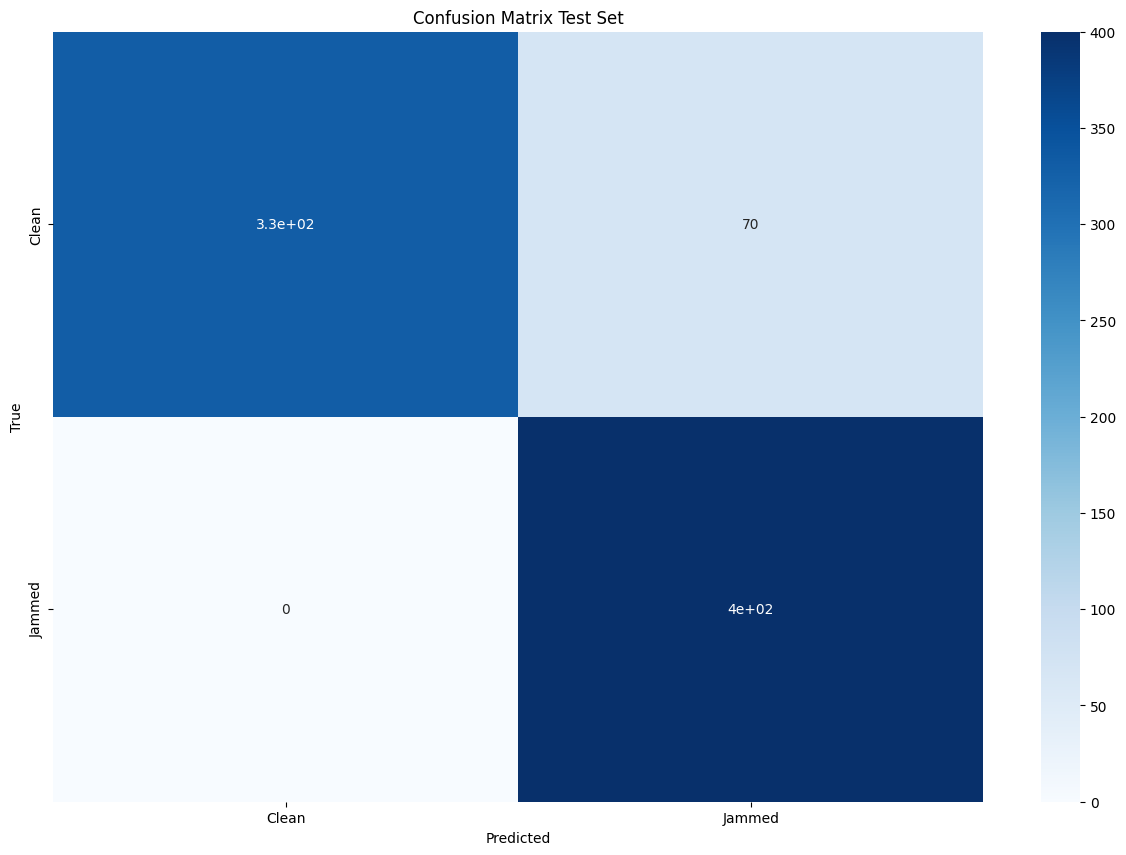

In [31]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold